## Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



### Загрузка данных

In [39]:
import os
import json
import requests
from typing import List, Dict, Tuple
from config import PATHS

import pandas as pd
import re
from collections import Counter

import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from collections import defaultdict

import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import AutoModel
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification
import torch
import transformers
from transformers import AutoTokenizer
import torch.nn as nn
import torch.optim as optim
from transformers import get_scheduler
from transformers import AutoModelForTokenClassification

from sklearn.metrics import hamming_loss, accuracy_score

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch.quantization
import time

In [40]:
RANDOM_SEED = 42

In [41]:
def download_file(url: str, save_path: str):
    """Скачивает файл по URL и сохраняет его по указанному пути"""
    # Создаём папку, если её ещё нет
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    print(f"Скачиваю данные из {url} ...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  # если ошибка — выбросит исключение
    
    with open(save_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    
    print(f"Файл сохранён: {save_path}")

if __name__ == "__main__":
    # Базовый URL и список файлов для скачивания
    BASE_URL = "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main"
    
    # Словарь: имя файла -> URL
    files_to_download = {
        'train.jsonl': f"{BASE_URL}/data/train.jsonl",
        'dev.jsonl': f"{BASE_URL}/data/dev.jsonl",
        'test.jsonl': f"{BASE_URL}/data/test.jsonl",
        'ent_types.jsonl': f"{BASE_URL}/ent_types.jsonl",
        'rel_types.jsonl': f"{BASE_URL}/rel_types.jsonl",
    }
    
    # Базовая директория для сохранения
    raw_data_dir = os.path.join('data', 'raw_data')
    
    # Скачиваем все файлы
    for filename, url in files_to_download.items():
        save_path = os.path.join(raw_data_dir, filename)
        try:
            download_file(url, save_path)
        except Exception as e:
            print(f"Ошибка при скачивании {filename}: {e}")
    
    print("\nВсе файлы скачаны")

Скачиваю данные из https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl ...
Файл сохранён: data\raw_data\train.jsonl
Скачиваю данные из https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/dev.jsonl ...
Файл сохранён: data\raw_data\dev.jsonl
Скачиваю данные из https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/test.jsonl ...
Файл сохранён: data\raw_data\test.jsonl
Скачиваю данные из https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl ...
Файл сохранён: data\raw_data\ent_types.jsonl
Скачиваю данные из https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl ...
Файл сохранён: data\raw_data\rel_types.jsonl

Все файлы скачаны


### Просмотр данных

In [42]:
# Читаем все файлы
files = ['train.jsonl', 'dev.jsonl', 'test.jsonl', 'ent_types.jsonl', 'rel_types.jsonl']
data = {}

for file in files:
    with open(f'data/raw_data/{file}', 'r', encoding='utf-8') as f:
        data[file.split('.')[0]] = [json.loads(line) for line in f]

# Статистика
for key, val in data.items():
    print(f"{key:12} {len(val):5} записей")

train          746 записей
dev             94 записей
test            93 записей
ent_types       29 записей
rel_types       49 записей


In [43]:
for name, content in data.items():
    print(f"\nПример из {name}:")
    df = pd.DataFrame(content[:5])
    display(df)
    print(f"Всего записей: {len(content)}")


Пример из train:


,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...


Всего записей: 746

Пример из dev:


,id,text,entities,relations,links
0,0,"Семья Обамы приобрела дом в Вашингтоне за 8,1 ...","[T1\tPERSON 60 71\tБарак Обама, T2\tPERSON 6 1...","[R1\tWORKS_AS Arg1:T32 Arg2:T6, R2\tWORKS_AS A...",[N1\tReference T11 Wikidata:Q13133\tМишель Оба...
1,1,Императору Японии разрешили сложить полномочия...,"[T1\tPROFESSION 0 10\tИмператору, T2\tCOUNTRY ...","[R1\tWORKS_AS Arg1:T7 Arg2:T36, R2\tSPOUSE Arg...","[N1\tReference T3 Wikidata:Q39018\tимператор, ..."
2,2,«Метро» Юрия Царёва в Доме Культуры\nЮрий Царё...,"[T1\tWORK_OF_ART 1 6\tМетро, T2\tPERSON 8 19\t...","[R1\tWORKS_AS Arg1:T9 Arg2:T14, R2\tWORKS_AS A...",[N1\tReference T1 Wikidata:Q5503\tметрополитен...
3,3,Важные перемены в жизни рэпера Jay Z: Он помен...,"[T1\tPERSON 31 36\tJay Z, T2\tPERSON 62 67\tJA...","[R1\tWORKS_AS Arg1:T6 Arg2:T5, R2\tALTERNATIVE...","[N1\tReference T1 Wikidata:Q62766\tJay-Z, N2\t..."
4,4,Лионель Месси женился\n\nЛионель Месси\nЗвезда...,"[T1\tPERSON 0 13\tЛионель Месси, T2\tPERSON 23...","[R1\tHEADQUARTERED_IN Arg1:T4 Arg2:T3, R2\tORI...",[N1\tReference T5 Wikidata:Q2365041\tАргентинц...


Всего записей: 94

Пример из test:


,id,text,entities,relations,links
0,0,"Словацкий тренер Жолт Хорняк возглавил ""Бананц...","[T1\tNATIONALITY 0 9\tСловацкий, T2\tPERSON 17...","[R1\tWORKPLACE Arg1:T2 Arg2:T3, R2\tHEADQUARTE...","[N1\tReference T5 Wikidata:Q171336\t, N2\tRefe..."
1,1,Глава департамента ЦБ РФ Надежда Иванова получ...,[T1\tPROFESSION 0 24\tГлава департамента ЦБ РФ...,"[R1\tWORKPLACE Arg1:T3 Arg2:T45, R2\tWORKS_AS ...","[N1\tReference T1 Wikidata:NULL\t, N2\tReferen..."
2,2,Умер самый старый миллиардер в мире Дэвид Рокф...,"[T1\tPERSON 150 173\tДэвид Рокфеллер старший, ...","[R1\tIDEOLOGY_OF Arg1:T23 Arg2:T20, R2\tFOUNDE...","[N1\tReference T9 Wikidata:Q17221\t, N2\tRefer..."
3,3,"Медалью ордена ""За заслуги перед Чувашской Рес...","[T1\tPROFESSION 66 73\tпремьер, T2\tAGE 75 84\...","[R1\tWORKS_AS Arg1:T8 Arg2:T7, R2\tWORKPLACE A...",[N1\tReference T3 Wikidata:Q14212\tпремьер-мин...
4,4,Depeche Mode выпустил новый альбом Spirit\n\nВ...,"[T1\tORGANIZATION 0 12\tDepeche Mode, T2\tWORK...","[R1\tWORKS_AS Arg1:T24 Arg2:T22, R2\tPARENT_OF...",[N1\tReference T1 Wikidata:Q482964\tDepeche Mo...


Всего записей: 93

Пример из ent_types:


,type,link
0,AGE,
1,AWARD,<NORM>:Wikidata
2,CITY,<NORM>:Wikidata
3,COUNTRY,<NORM>:Wikidata
4,CRIME,


Всего записей: 29

Пример из rel_types:


,type,arg1,arg2
0,ABBREVIATION,[<ENTITY>],[<ENTITY>]
1,KNOWS,"[PERSON, PROFESSION]",[<ENTITY>]
2,AGE_IS,[<ENTITY>],[AGE]
3,AGE_DIED_AT,"[PERSON, PROFESSION]",[AGE]
4,ALTERNATIVE_NAME,[<ENTITY>],[<ENTITY>]


Всего записей: 49


In [44]:
train, dev, test, ent_types, rel_types = data['train'], data['dev'], data['test'], data['ent_types'], data['rel_types']

In [45]:
ent_types= pd.DataFrame(ent_types)
print(ent_types['type'].unique())
print(ent_types['type'].nunique())


rel_types = pd.DataFrame(rel_types)
print(rel_types['type'].unique())
print(rel_types['type'].nunique())

['AGE' 'AWARD' 'CITY' 'COUNTRY' 'CRIME' 'DATE' 'DISEASE' 'DISTRICT'
 'EVENT' 'FACILITY' 'FAMILY' 'IDEOLOGY' 'LANGUAGE' 'LAW' 'LOCATION'
 'MONEY' 'NATIONALITY' 'NUMBER' 'ORDINAL' 'ORGANIZATION' 'PENALTY'
 'PERCENT' 'PERSON' 'PRODUCT' 'PROFESSION' 'RELIGION' 'STATE_OR_PROVINCE'
 'TIME' 'WORK_OF_ART']
29
['ABBREVIATION' 'KNOWS' 'AGE_IS' 'AGE_DIED_AT' 'ALTERNATIVE_NAME'
 'AWARDED_WITH' 'PLACE_OF_BIRTH' 'CAUSE_OF_DEATH' 'DATE_DEFUNCT_IN'
 'DATE_FOUNDED_IN' 'DATE_OF_BIRTH' 'DATE_OF_CREATION' 'DATE_OF_DEATH'
 'POINT_IN_TIME' 'PLACE_OF_DEATH' 'FOUNDED_BY' 'HEADQUARTERED_IN'
 'IDEOLOGY_OF' 'LOCATED_IN' 'SPOUSE' 'MEDICAL_CONDITION' 'MEMBER_OF'
 'ORGANIZES' 'ORIGINS_FROM' 'OWNER_OF' 'PARENT_OF' 'PLACE_RESIDES_IN'
 'PRICE_OF' 'PRODUCES' 'RELATIVE' 'RELIGION_OF' 'SCHOOLS_ATTENDED'
 'SIBLING' 'SUBEVENT_OF' 'SUBORDINATE_OF' 'TAKES_PLACE_IN' 'WORKPLACE'
 'WORKS_AS' 'START_TIME' 'END_TIME' 'CONVICTED_OF' 'PENALIZED_AS'
 'PART_OF' 'HAS_CAUSE' 'AGENT' 'PARTICIPANT_IN' 'INANIMATE_INVOLVED'
 'EXPENDITURE' 

In [46]:
train= pd.DataFrame(train).reset_index(drop=True)
train.head()

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...


In [47]:
dev = pd.DataFrame(dev).reset_index(drop=True)
dev.head()

,id,text,entities,relations,links
0,0,"Семья Обамы приобрела дом в Вашингтоне за 8,1 ...","[T1\tPERSON 60 71\tБарак Обама, T2\tPERSON 6 1...","[R1\tWORKS_AS Arg1:T32 Arg2:T6, R2\tWORKS_AS A...",[N1\tReference T11 Wikidata:Q13133\tМишель Оба...
1,1,Императору Японии разрешили сложить полномочия...,"[T1\tPROFESSION 0 10\tИмператору, T2\tCOUNTRY ...","[R1\tWORKS_AS Arg1:T7 Arg2:T36, R2\tSPOUSE Arg...","[N1\tReference T3 Wikidata:Q39018\tимператор, ..."
2,2,«Метро» Юрия Царёва в Доме Культуры\nЮрий Царё...,"[T1\tWORK_OF_ART 1 6\tМетро, T2\tPERSON 8 19\t...","[R1\tWORKS_AS Arg1:T9 Arg2:T14, R2\tWORKS_AS A...",[N1\tReference T1 Wikidata:Q5503\tметрополитен...
3,3,Важные перемены в жизни рэпера Jay Z: Он помен...,"[T1\tPERSON 31 36\tJay Z, T2\tPERSON 62 67\tJA...","[R1\tWORKS_AS Arg1:T6 Arg2:T5, R2\tALTERNATIVE...","[N1\tReference T1 Wikidata:Q62766\tJay-Z, N2\t..."
4,4,Лионель Месси женился\n\nЛионель Месси\nЗвезда...,"[T1\tPERSON 0 13\tЛионель Месси, T2\tPERSON 23...","[R1\tHEADQUARTERED_IN Arg1:T4 Arg2:T3, R2\tORI...",[N1\tReference T5 Wikidata:Q2365041\tАргентинц...


In [48]:
test = pd.DataFrame(test).reset_index(drop=True)
test.head()

,id,text,entities,relations,links
0,0,"Словацкий тренер Жолт Хорняк возглавил ""Бананц...","[T1\tNATIONALITY 0 9\tСловацкий, T2\tPERSON 17...","[R1\tWORKPLACE Arg1:T2 Arg2:T3, R2\tHEADQUARTE...","[N1\tReference T5 Wikidata:Q171336\t, N2\tRefe..."
1,1,Глава департамента ЦБ РФ Надежда Иванова получ...,[T1\tPROFESSION 0 24\tГлава департамента ЦБ РФ...,"[R1\tWORKPLACE Arg1:T3 Arg2:T45, R2\tWORKS_AS ...","[N1\tReference T1 Wikidata:NULL\t, N2\tReferen..."
2,2,Умер самый старый миллиардер в мире Дэвид Рокф...,"[T1\tPERSON 150 173\tДэвид Рокфеллер старший, ...","[R1\tIDEOLOGY_OF Arg1:T23 Arg2:T20, R2\tFOUNDE...","[N1\tReference T9 Wikidata:Q17221\t, N2\tRefer..."
3,3,"Медалью ордена ""За заслуги перед Чувашской Рес...","[T1\tPROFESSION 66 73\tпремьер, T2\tAGE 75 84\...","[R1\tWORKS_AS Arg1:T8 Arg2:T7, R2\tWORKPLACE A...",[N1\tReference T3 Wikidata:Q14212\tпремьер-мин...
4,4,Depeche Mode выпустил новый альбом Spirit\n\nВ...,"[T1\tORGANIZATION 0 12\tDepeche Mode, T2\tWORK...","[R1\tWORKS_AS Arg1:T24 Arg2:T22, R2\tPARENT_OF...",[N1\tReference T1 Wikidata:Q482964\tDepeche Mo...


### EDA

In [49]:
# Преобразуем в единый большой DataFrame для анализа
all_df = pd.concat([train, dev, test], ignore_index=True)

In [50]:
print(f"Пропуски по колонкам ent_types:\n{ent_types.isna().sum()}")
print(f"Дубликаты по ent_types: {ent_types.duplicated().sum()}")

Пропуски по колонкам ent_types:
type    0
link    0
dtype: int64
Дубликаты по ent_types: 0


In [51]:
print(f"Пропуски по колонкам rel_types:\n{rel_types.isna().sum()}")
print(f"Дубликаты по отношениям rel_types: {rel_types.duplicated(subset=['type']).sum()}")

Пропуски по колонкам rel_types:
type    0
arg1    0
arg2    0
dtype: int64
Дубликаты по отношениям rel_types: 0


In [52]:
print(f"Пропуски по df_all:\n{all_df.isna().sum()}")
print(f"Дубликаты по текстовой колонке all_df: {all_df.duplicated(subset=['text']).sum()}")

Пропуски по df_all:
id           0
text         0
entities     0
relations    0
links        0
dtype: int64
Дубликаты по текстовой колонке all_df: 0


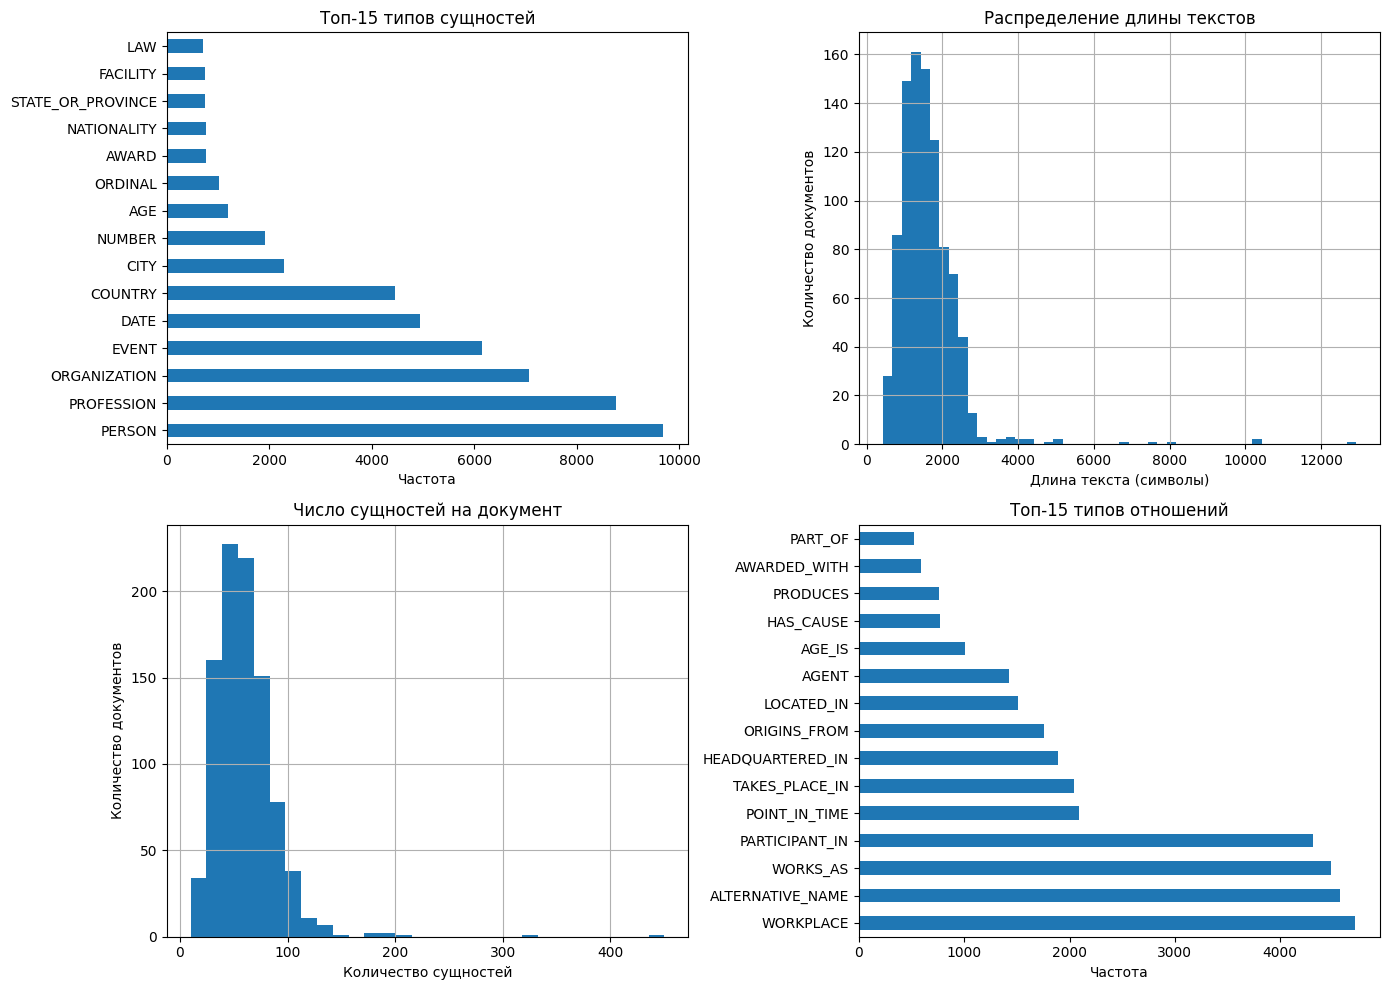

Топ-15 типов сущностей:
PERSON               9687
PROFESSION           8758
ORGANIZATION         7067
EVENT                6152
DATE                 4936
COUNTRY              4444
CITY                 2293
NUMBER               1912
AGE                  1193
ORDINAL              1019
AWARD                 767
NATIONALITY           754
STATE_OR_PROVINCE     750
FACILITY              741
LAW                   713
Name: count, dtype: int64
Топ-15 типов отношений:
WORKPLACE           4712
ALTERNATIVE_NAME    4565
WORKS_AS            4478
PARTICIPANT_IN      4307
POINT_IN_TIME       2086
TAKES_PLACE_IN      2039
HEADQUARTERED_IN    1892
ORIGINS_FROM        1761
LOCATED_IN          1508
AGENT               1424
AGE_IS              1008
HAS_CAUSE            770
PRODUCES             756
AWARDED_WITH         587
PART_OF              519
Name: count, dtype: int64
Всего уникальных типов сущностей: 29
Всего уникальных типов отношений: 49

Средняя длина текста: 1619 символов
Среднее число сущностей 

In [53]:

# Извлекаем типы сущностей
entity_types = []
for entities in all_df['entities']:
    if entities:
        types = [e.split('\t')[1].split()[0] for e in entities]
        entity_types.extend(types)

# Извлекаем типы отношений
relation_types = []
for relations in all_df['relations']:
    if relations:
        types = [r.split('\t')[1].split()[0] for r in relations]
        relation_types.extend(types)

# Считаем число сущностей на документ
entities_per_doc = all_df['entities'].apply(lambda x: len(x) if x else 0)

# Длина текстов
text_lengths = all_df['text'].apply(len)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Топ-15 типов сущностей

pd.Series(entity_types).value_counts().head(15).plot(kind='barh', ax=axes[0,0])
axes[0,0].set_title('Топ-15 типов сущностей')
axes[0,0].set_xlabel('Частота')

# Распределение длины текстов
text_lengths.hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Распределение длины текстов')
axes[0,1].set_xlabel('Длина текста (символы)')
axes[0,1].set_ylabel('Количество документов')

# Число сущностей на документ
entities_per_doc.hist(bins=30, ax=axes[1,0])
axes[1,0].set_title('Число сущностей на документ')
axes[1,0].set_xlabel('Количество сущностей')
axes[1,0].set_ylabel('Количество документов')

# Топ-15 типов отношений
pd.Series(relation_types).value_counts().head(15).plot(kind='barh', ax=axes[1,1])
axes[1,1].set_title('Топ-15 типов отношений')
axes[1,1].set_xlabel('Частота')

plt.tight_layout()
plt.show()

# Статистика
print(f"Топ-15 типов сущностей:\n{pd.Series(entity_types).value_counts().head(15)}")
print(f"Топ-15 типов отношений:\n{pd.Series(relation_types).value_counts().head(15)}")
print(f"Всего уникальных типов сущностей: {len(set(entity_types))}")
print(f"Всего уникальных типов отношений: {len(set(relation_types))}")
print(f"\nСредняя длина текста: {text_lengths.mean():.0f} символов")
print(f"Среднее число сущностей на документ: {entities_per_doc.mean():.1f}")

In [54]:
# Берём первый документ из train
example = train.iloc[0]

print("СУЩНОСТИ:")
for entity in example['entities'][:20]:  # первые 20
    print(entity)


print("ОТНОШЕНИЯ:")

for relation in example['relations'][:20]:  # первые 20
    print(relation)

print(f"\nВсего сущностей: {len(example['entities'])}")
print(f"Всего отношений: {len(example['relations'])}")

СУЩНОСТИ:
T1	NATIONALITY 62 74	американцами
T2	CITY 82 89	Бишкеке
T3	DATE 117 126	5 августа
T4	COUNTRY 136 142	Грузия
T5	ORGANIZATION 145 179	Правоохранительные органы Киргизии
T6	COUNTRY 171 179	Киргизии
T7	COUNTRY 221 224	США
T8	CITY 227 234	Бишкеке
T9	DATE 288 298	во вторник
T10	ORGANIZATION 312 315	МВД
T11	DATE 91 101	05/08/2008
T12	CITY 433 440	Ынтымак
T13	AGE 464 474	66-летнему
T14	COUNTRY 486 494	Киргизии
T15	COUNTRY 519 522	США
T16	NUMBER 545 550	шесть
T17	NUMBER 631 633	26
T18	NUMBER 652 667	5,56 миллиметра
T19	NUMBER 669 672	два
T20	PRODUCT 690 697	МОСВЕГА
ОТНОШЕНИЯ:
R1	TAKES_PLACE_IN Arg1:T70 Arg2:T12
R2	AGE_IS Arg1:T101 Arg2:T13
R3	HEADQUARTERED_IN Arg1:T72 Arg2:T4
R4	HEADQUARTERED_IN Arg1:T5 Arg2:T6
R5	HEADQUARTERED_IN Arg1:T42 Arg2:T73
R6	ORGANIZES Arg1:T5 Arg2:T70
R7	LOCATED_IN Arg1:T12 Arg2:T8
R8	LOCATED_IN Arg1:T8 Arg2:T6
R9	OWNER_OF Arg1:T101 Arg2:T12
R10	SUBEVENT_OF Arg1:T106 Arg2:T70
R11	HEADQUARTERED_IN Arg1:T82 Arg2:T83
R12	WORKPLACE Arg1:T88 Arg2:T89
R13	HEADQUAR

### Вывод после EDA

- Данные выглядят нормально, читаемо, понятно
- В train: 746 записей, в dev: 94 записи, в test: 93 записи.

- Пропусков и дубликатов не было

- ent_types: 29 записей, то есть 29 уникальных типов фактов (отношений между сущностями)

- rel_types: 49 записей, то есть 49 уникательных типв фактов

- Средняя длина текста: 1619 символов

- Среднее число сущностей на документ: 60.3

- Топ-5 типов сущностей:
1) PERSON               9687
2) PROFESSION           8758
3) ORGANIZATION         7067
4) EVENT                6152
5) DATE                 4936

- Топ-5 типов фактов:
1) WORKPLACE           4712
2) ALTERNATIVE_NAME    4565
3) WORKS_AS            4478
4) PARTICIPANT_IN      4307
5) POINT_IN_TIME       2086


### Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.


In [55]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [56]:
parse_relation_line(train.iloc[0]['relations'][0])

{'id': 'R1', 'type': 'TAKES_PLACE_IN', 'arg1': 'T70', 'arg2': 'T12'}

In [57]:
parse_entity_line(train.iloc[0]['entities'][0])

{'id': 'T1',
 'type': 'NATIONALITY',
 'start': 62,
 'end': 74,
 'text': 'американцами'}

In [58]:
train

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...
...,...,...,...,...,...
741,741,Эрдоган: брюссельский террорист был ранее заде...,"[T1\tPERSON 0 7\tЭрдоган, T2\tCITY 9 21\tбрюсс...","[R1\tWORKS_AS Arg1:T13 Arg2:T44, R2\tWORKPLACE...",[N1\tReference T1 Wikidata:Q39259\tРеджеп Тайи...
742,742,Международный трибунал приговорил Радована Кар...,[T1\tORGANIZATION 0 22\tМеждународный трибунал...,"[R1\tTAKES_PLACE_IN Arg1:T36 Arg2:T10, R2\tCON...","[N1\tReference T5 Wikidata:NULL\t, N2\tReferen..."
743,743,Социальные сети — причина депрессии\n«Социальн...,[T1\tORGANIZATION 150 191\tМедицинской школы У...,"[R1\tWORKS_AS Arg1:T8 Arg2:T24, R2\tWORKS_AS A...","[N1\tReference T1 Wikidata:Q7896139\t, N2\tRef..."
744,744,Концерт Rolling Stones в Гаване собрал 500 тыс...,"[T1\tEVENT 0 7\tКонцерт, T2\tORGANIZATION 8 22...","[R1\tTAKES_PLACE_IN Arg1:T1 Arg2:T3, R2\tPOINT...",[N1\tReference T5 Wikidata:Q11036\tThe Rolling...


In [59]:
train['text'].iloc[0]

'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмечает, что на момент

In [60]:
train['entities'].iloc[0]

['T1\tNATIONALITY 62 74\tамериканцами',
 'T2\tCITY 82 89\tБишкеке',
 'T3\tDATE 117 126\t5 августа',
 'T4\tCOUNTRY 136 142\tГрузия',
 'T5\tORGANIZATION 145 179\tПравоохранительные органы Киргизии',
 'T6\tCOUNTRY 171 179\tКиргизии',
 'T7\tCOUNTRY 221 224\tСША',
 'T8\tCITY 227 234\tБишкеке',
 'T9\tDATE 288 298\tво вторник',
 'T10\tORGANIZATION 312 315\tМВД',
 'T11\tDATE 91 101\t05/08/2008',
 'T12\tCITY 433 440\tЫнтымак',
 'T13\tAGE 464 474\t66-летнему',
 'T14\tCOUNTRY 486 494\tКиргизии',
 'T15\tCOUNTRY 519 522\tСША',
 'T16\tNUMBER 545 550\tшесть',
 'T17\tNUMBER 631 633\t26',
 'T18\tNUMBER 652 667\t5,56 миллиметра',
 'T19\tNUMBER 669 672\tдва',
 'T20\tPRODUCT 690 697\tМОСВЕГА',
 'T21\tNUMBER 713 719\tчетыре',
 'T22\tNUMBER 758 761\tдва',
 'T23\tNUMBER 788 794\tчетыре',
 'T24\tNUMBER 855 860\tшесть',
 'T25\tNUMBER 880 893\t9 миллиметров',
 'T26\tPRODUCT 900 907\tБеретта',
 'T27\tNUMBER 909 913\tодна',
 'T28\tORGANIZATION 949 952\tМВД',
 'T29\tNUMBER 1098 1100\t10',
 'T30\tCOUNTRY 1136 1139\

In [61]:
train['entity_tags'] = train['entities'].apply(
    lambda x: [parse_entity_line(line) for line in x if x] if x else []
)

dev['entity_tags'] = dev['entities'].apply(
    lambda x: [parse_entity_line(line) for line in x if x] if x else []
)

test['entity_tags'] = test['entities'].apply(
    lambda x: [parse_entity_line(line) for line in x if x] if x else []
)

In [62]:
def whitespace_tokenize_with_offsets(text: str):
    tokens = []
    spans = []
    for m in re.finditer(r'\S+', text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

In [63]:
def assign_bio_tags(tokens, token_spans, entities):
    """
    Создаёт BIO-разметку для токенов на основе сущностей
    
    tokens: список токенов
    token_spans: список (start, end) для каждого токена
    entities: список распарсенных сущностей [{id, type, start, end, text}, ...]
    """
    tags = ["O"] * len(tokens)
    
    for entity in entities:
        if not entity:
            continue
        ent_start, ent_end = entity['start'], entity['end']
        ent_type = entity['type']
        
        is_first = True
        for i, (tok_start, tok_end) in enumerate(token_spans):
            # Проверяем пересечение токена с сущностью
            if tok_start >= ent_start and tok_end <= ent_end:
                if is_first:
                    tags[i] = f"B-{ent_type}"
                    is_first = False
                else:
                    tags[i] = f"I-{ent_type}"
    
    return tags

# Использование
def process_document(text, entity_tags):
    tokens, token_spans = whitespace_tokenize_with_offsets(text)
    tags = assign_bio_tags(tokens, token_spans, entity_tags)
    return tokens, token_spans, tags

# Применяем ко всему датасету
train['processed'] = train.apply(
    lambda row: process_document(row['text'], row['entity_tags']), 
    axis=1
)

test['processed'] = test.apply(
    lambda row: process_document(row['text'], row['entity_tags']), 
    axis=1
)

dev['processed'] = dev.apply(
    lambda row: process_document(row['text'], row['entity_tags']), 
    axis=1
)

# Распаковываем результаты
train['tokens'] = train['processed'].apply(lambda x: x[0])
train['token_spans'] = train['processed'].apply(lambda x: x[1])
train['bio_tags'] = train['processed'].apply(lambda x: x[2])

test['tokens'] = test['processed'].apply(lambda x: x[0])
test['token_spans'] = test['processed'].apply(lambda x: x[1])
test['bio_tags'] = test['processed'].apply(lambda x: x[2])

dev['tokens'] = dev['processed'].apply(lambda x: x[0])
dev['token_spans'] = dev['processed'].apply(lambda x: x[1])
dev['bio_tags'] = dev['processed'].apply(lambda x: x[2])

# Проверка
print(train[['tokens', 'bio_tags']].iloc[0])

tokens      [Пулеметы,, автоматы, и, снайперские, винтовки...
bio_tags    [O, O, O, O, O, O, O, O, B-NATIONALITY, O, O, ...
Name: 0, dtype: object


BIO-теги добавили, теперь перейдем к векторам с отношениями

In [64]:
train['relation_tags'] = train['relations'].apply(
    lambda x: [parse_relation_line(line) for line in x if x] if x else []
)

dev['relation_tags'] = dev['relations'].apply(
    lambda x: [parse_relation_line(line) for line in x if x] if x else []
)

test['relation_tags'] = test['relations'].apply(
    lambda x: [parse_relation_line(line) for line in x if x] if x else []
)

In [65]:
train.head()

,id,text,entities,relations,links,entity_tags,processed,tokens,token_spans,bio_tags,relation_tags
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\...","[{'id': 'T1', 'type': 'NATIONALITY', 'start': ...","([Пулеметы,, автоматы, и, снайперские, винтовк...","[Пулеметы,, автоматы, и, снайперские, винтовки...","[(0, 9), (10, 18), (19, 20), (21, 32), (33, 41...","[O, O, O, O, O, O, O, O, B-NATIONALITY, O, O, ...","[{'id': 'R1', 'type': 'TAKES_PLACE_IN', 'arg1'..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen...","[{'id': 'T1', 'type': 'PERSON', 'start': 0, 'e...","([Муртаза, Рахимов, чистит, кадры, Президент, ...","[Муртаза, Рахимов, чистит, кадры, Президент, Б...","[(0, 7), (8, 15), (16, 22), (23, 28), (31, 40)...","[B-PERSON, I-PERSON, O, O, B-PROFESSION, I-PRO...","[{'id': 'R1', 'type': 'WORKS_AS', 'arg1': 'T3'..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...,"[{'id': 'T1', 'type': 'COUNTRY', 'start': 0, '...","([Россия, задерживает, поставку, генсека, Сего...","[Россия, задерживает, поставку, генсека, Сегод...","[(0, 6), (7, 18), (19, 27), (28, 35), (38, 45)...","[B-COUNTRY, O, O, B-PROFESSION, B-DATE, O, B-C...","[{'id': 'R1', 'type': 'ALTERNATIVE_NAME', 'arg..."
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...,"[{'id': 'T1', 'type': 'COUNTRY', 'start': 0, '...","([Российские, менеджеры, отказались, возглавля...","[Российские, менеджеры, отказались, возглавлят...","[(0, 10), (11, 20), (21, 31), (32, 43), (44, 5...","[B-COUNTRY, B-PROFESSION, O, O, O, O, B-ORGANI...","[{'id': 'R1', 'type': 'ALTERNATIVE_NAME', 'arg..."
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...,"[{'id': 'T1', 'type': 'ORGANIZATION', 'start':...","([Facebook, нашел, нового, финансового, директ...","[Facebook, нашел, нового, финансового, директо...","[(0, 8), (9, 14), (15, 21), (22, 33), (34, 43)...","[B-ORGANIZATION, O, O, B-PROFESSION, I-PROFESS...","[{'id': 'R1', 'type': 'AGE_IS', 'arg1': 'T6', ..."


In [66]:
def build_multihot_vector(relation_tags, top_k_relations):
    """
    Создаёт multihot вектор для типов отношений
    
    relation_tags: список распарсенных отношений [{type: ..., arg1: ..., arg2: ...}, ...]
    all_relation_types: список всех возможных типов отношений
    """
    # Создаём вектор из нулей
    cls_vec = [0] * len(top_k_relations)
    
    
    # Собираем типы отношений из документа
    doc_rel_types = set(rel['type'] for rel in relation_tags if rel)
  
    # Ставим 1 для найденных типов
    for i, rel_type in enumerate(top_k_relations):
        if rel_type in doc_rel_types:
            cls_vec[i] = 1
    return cls_vec


Если взять все типы отношений, классов будет почти 50, и модель наверняка будет плохо учиться.
Поэтому берем только самые частые классы (30).

In [67]:
# Получаем все уникальные типы отношений из датасета
all_relation_types = sorted(set(
    rel['type'] 
    for relations in train['relation_tags'] 
    for rel in relations 
    if rel
))

# Топ-30 самых частых
top_k_relations = pd.Series(all_relation_types).value_counts().head(30).index.tolist()

print(f"Топ-30 типов отношений:")
print(top_k_relations)

Топ-30 типов отношений:
['ABBREVIATION', 'AGENT', 'AGE_DIED_AT', 'AGE_IS', 'ALTERNATIVE_NAME', 'AWARDED_WITH', 'CAUSE_OF_DEATH', 'CONVICTED_OF', 'DATE_DEFUNCT_IN', 'DATE_FOUNDED_IN', 'DATE_OF_BIRTH', 'DATE_OF_CREATION', 'DATE_OF_DEATH', 'END_TIME', 'EXPENDITURE', 'FOUNDED_BY', 'HAS_CAUSE', 'HEADQUARTERED_IN', 'IDEOLOGY_OF', 'INANIMATE_INVOLVED', 'INCOME', 'KNOWS', 'LOCATED_IN', 'MEDICAL_CONDITION', 'MEMBER_OF', 'ORGANIZES', 'ORIGINS_FROM', 'OWNER_OF', 'PARENT_OF', 'PARTICIPANT_IN']


In [68]:

# Создаём multihot векторы для каждого документа
train['cls_vec'] = train['relation_tags'].apply(
    lambda x: build_multihot_vector(x, top_k_relations)
)

#Создаём multihot векторы для каждого документа
dev['cls_vec'] = train['relation_tags'].apply(
    lambda x: build_multihot_vector(x, top_k_relations)
)

#Создаём multihot векторы для каждого документа
test['cls_vec'] = train['relation_tags'].apply(
    lambda x: build_multihot_vector(x, top_k_relations)
)

#  Проверяем
print("\nПример:")
print(f"Отношения: {train['relation_tags'].iloc[0]}")
print(f"Multihot:  {train['cls_vec'].iloc[0]}")
print(f"Длина:     {len(train['cls_vec'].iloc[0])}")


Пример:
Отношения: [{'id': 'R1', 'type': 'TAKES_PLACE_IN', 'arg1': 'T70', 'arg2': 'T12'}, {'id': 'R2', 'type': 'AGE_IS', 'arg1': 'T101', 'arg2': 'T13'}, {'id': 'R3', 'type': 'HEADQUARTERED_IN', 'arg1': 'T72', 'arg2': 'T4'}, {'id': 'R4', 'type': 'HEADQUARTERED_IN', 'arg1': 'T5', 'arg2': 'T6'}, {'id': 'R5', 'type': 'HEADQUARTERED_IN', 'arg1': 'T42', 'arg2': 'T73'}, {'id': 'R6', 'type': 'ORGANIZES', 'arg1': 'T5', 'arg2': 'T70'}, {'id': 'R7', 'type': 'LOCATED_IN', 'arg1': 'T12', 'arg2': 'T8'}, {'id': 'R8', 'type': 'LOCATED_IN', 'arg1': 'T8', 'arg2': 'T6'}, {'id': 'R9', 'type': 'OWNER_OF', 'arg1': 'T101', 'arg2': 'T12'}, {'id': 'R10', 'type': 'SUBEVENT_OF', 'arg1': 'T106', 'arg2': 'T70'}, {'id': 'R11', 'type': 'HEADQUARTERED_IN', 'arg1': 'T82', 'arg2': 'T83'}, {'id': 'R12', 'type': 'WORKPLACE', 'arg1': 'T88', 'arg2': 'T89'}, {'id': 'R13', 'type': 'HEADQUARTERED_IN', 'arg1': 'T54', 'arg2': 'T56'}, {'id': 'R14', 'type': 'ALTERNATIVE_NAME', 'arg1': 'T56', 'arg2': 'T55'}, {'id': 'R15', 'type':

Сделаем sanity-check: для 5 случайных примеров выведите текст — токены — BIO — cls_vec.

In [69]:
dev[['text', 'cls_vec', 'tokens', 'bio_tags']]

,text,cls_vec,tokens,bio_tags
0,"Семья Обамы приобрела дом в Вашингтоне за 8,1 ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Семья, Обамы, приобрела, дом, в, Вашингтоне, ...","[B-FAMILY, I-FAMILY, B-EVENT, I-EVENT, O, B-CI..."
1,Императору Японии разрешили сложить полномочия...,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Императору, Японии, разрешили, сложить, полно...","[B-PROFESSION, I-PROFESSION, O, O, O, B-PROFES..."
2,«Метро» Юрия Царёва в Доме Культуры\nЮрий Царё...,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[«Метро», Юрия, Царёва, в, Доме, Культуры, Юри...","[O, B-PERSON, I-PERSON, O, B-FACILITY, I-FACIL..."
3,Важные перемены в жизни рэпера Jay Z: Он помен...,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Важные, перемены, в, жизни, рэпера, Jay, Z:, ...","[O, O, O, O, B-PROFESSION, B-PERSON, O, O, O, ..."
4,Лионель Месси женился\n\nЛионель Месси\nЗвезда...,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Лионель, Месси, женился, Лионель, Месси, Звез...","[B-PERSON, I-PERSON, B-EVENT, B-PERSON, I-PERS..."
...,...,...,...,...
89,Двадцать семь кандидатов претендуют на пост пр...,"[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[Двадцать, семь, кандидатов, претендуют, на, п...","[B-NUMBER, I-NUMBER, O, O, O, O, B-PROFESSION,..."
90,В Татарстане клан Шаймиевых расширяет семейный...,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...","[В, Татарстане, клан, Шаймиевых, расширяет, се...","[O, B-STATE_OR_PROVINCE, B-FAMILY, I-FAMILY, O..."
91,"Мать Майкла Джексона рассказала, как она «исче...","[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[Мать, Майкла, Джексона, рассказала,, как, она...","[O, B-PERSON, I-PERSON, O, O, O, O, B-DATE, I-..."
92,Рособрнадзор возглавил 30-летний чиновник\nРос...,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...","[Рособрнадзор, возглавил, 30-летний, чиновник,...","[B-ORGANIZATION, O, B-AGE, B-PROFESSION, B-ORG..."


Выглядит нормально.

### Токенизация и выравнивание меток

In [70]:
# Создаём примеры для каждой части отдельно
def prepare_examples(df):
    examples = []
    for idx, row in df.iterrows():
        examples.append({
            'text': row['text'],
            'tokens': row['tokens'],
            'tags': row['bio_tags'],
            'cls_labels': row['cls_vec']
        })
    return examples

# Подготавливаем каждую часть
train_examples = prepare_examples(train)
dev_examples = prepare_examples(dev)
test_examples = prepare_examples(test)

# Создаём label2id из всех частей
unique_labels = set()
for ex in train_examples + dev_examples + test_examples:
    unique_labels.update(ex["tags"])

label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

print(f"Всего уникальных меток: {len(label_list)}")

# Преобразуем теги в числа
for ex in train_examples + dev_examples + test_examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]

# Создаём DatasetDict с готовым разбиением
dataset = DatasetDict({
    "train": Dataset.from_list(train_examples),
    "dev": Dataset.from_list(dev_examples),
    "test": Dataset.from_list(test_examples)
})

print(dataset)

Всего уникальных меток: 58
DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'tags', 'cls_labels'],
        num_rows: 746
    })
    dev: Dataset({
        features: ['text', 'tokens', 'tags', 'cls_labels'],
        num_rows: 94
    })
    test: Dataset({
        features: ['text', 'tokens', 'tags', 'cls_labels'],
        num_rows: 93
    })
})


In [71]:
train_examples[0]['tags']

[57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 16,
 57,
 57,
 2,
 27,
 55,
 57,
 5,
 34,
 57,
 19,
 47,
 3,
 57,
 57,
 57,
 57,
 16,
 44,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 5,
 34,
 19,
 47,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 0,
 16,
 44,
 57,
 57,
 16,
 57,
 8,
 37,
 57,
 17,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 17,
 57,
 57,
 17,
 57,
 17,
 57,
 57,
 23,
 17,
 57,
 17,
 57,
 57,
 57,
 57,
 17,
 57,
 57,
 17,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 17,
 57,
 57,
 17,
 45,
 57,
 57,
 17,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 24,
 52,
 57,
 57,
 57,
 57,
 57,
 17,
 57,
 57,
 57,
 57,
 3,
 57,
 57,
 57,
 57,
 24,
 52,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 17,
 57,
 57,
 57,
 17,
 57,
 17,
 57,
 57,
 57,
 17,
 57,
 17,
 57,
 57,
 57,
 17,
 57,
 57,
 57,
 17,
 57,
 57,
 57,
 17,
 45,
 57,
 57,
 17,
 57,
 57,
 57,
 5

In [72]:
# Выбираем токенизатор (для русского языка)
model_name = "DeepPavlov/rubert-base-cased"  
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

print(f"Токенизатор: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size}")

Токенизатор: DeepPavlov/rubert-base-cased
Vocab size: 119547


In [73]:
def tokenize_and_align_labels(examples_batch, max_length=128):
    """
    Токенизирует текст и выравнивает метки:
    - Для субтокенов ставим -100 (игнорируем при обучении)
    - Для первых токенов слова ставим соответствующую метку
    """
    tokenized = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    
    labels = []
    for i, word_labels in enumerate(examples_batch["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                # Специальные токены [CLS], [SEP], [PAD]
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                # Первый токен слова → ставим метку
                label_ids.append(word_labels[word_idx])
            else:
                # Субтокен → игнорируем
                label_ids.append(-100)
            prev_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized["labels"] = labels
    tokenized["cls_labels"] = examples_batch["cls_labels"]  # Добавляем cls_labels
    
    return tokenized

# Применяем токенизацию
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "tags"]
)

print(tokenized_dataset)
print("\nПример из train:")
print(tokenized_dataset["train"][0])

Map: 100%|██████████| 93/93 [00:00<00:00, 2785.34 examples/s]

DatasetDict({
    train: Dataset({
        features: ['cls_labels', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 746
    })
    dev: Dataset({
        features: ['cls_labels', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 94
    })
    test: Dataset({
        features: ['cls_labels', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 93
    })
})

Пример из train:
{'cls_labels': [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0], 'input_ids': [101, 95305, 4262, 128, 60277, 851, 42540, 3648, 38472, 42203, 845, 23801, 59297, 52997, 13507, 845, 76911, 11343, 134, 11564, 134, 6564, 3955, 156, 9452, 113798, 112636, 31226, 128, 146, 6023, 134, 9580, 130, 28076, 134, 132, 50863, 16597, 23139, 18023, 845, 13507, 128, 23801, 59297, 34768, 4425, 845, 76911, 128, 114749, 128, 60277, 851, 42540, 3648, 38472, 128, 4721, 2743, 14650, 8609, 130, 17164, 12618, 23139, 132,

In [74]:
class CustomDataCollator(DataCollatorForTokenClassification):
    """
    Расширенный collator, который также обрабатывает cls_labels
    """
    def __call__(self, features):
        # Извлекаем cls_labels отдельно
        cls_labels = [f.pop("cls_labels") for f in features]
        
        # Стандартная обработка для token classification
        batch = super().__call__(features)
        
        # Добавляем cls_labels в батч
        batch["cls_labels"] = torch.tensor(cls_labels, dtype=torch.float)
        
        return batch

# Создаём collator
data_collator = CustomDataCollator(tokenizer, padding=True)

In [75]:
# Создаём DataLoader'ы

train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

dev_dataloader = DataLoader(
    tokenized_dataset["dev"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

print(f"Train batches: {len(train_dataloader)}")
print(f"Dev batches: {len(dev_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# Проверка батча
batch = next(iter(train_dataloader))
print("\nСтруктура батча:")
for key, val in batch.items():
    if isinstance(val, torch.Tensor):
        print(f"  {key}: {val.shape}")

Train batches: 47
Dev batches: 6
Test batches: 6

Структура батча:
  input_ids: torch.Size([16, 128])
  token_type_ids: torch.Size([16, 128])
  attention_mask: torch.Size([16, 128])
  labels: torch.Size([16, 128])
  cls_labels: torch.Size([16, 30])


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Модель: `JointModel` + custom loss (uncertainty weighting)


Опытным путем выяснилось, что нужно больше эпох и focal loss для редких и сложных примеров для обеих голов, но  с меньшим весом для головы классификации по отношениям.

In [77]:
class JointModel(nn.Module):
    def __init__(self, model_name, num_labels, num_cls_labels, 
                 use_uncertainty_weight=True, 
                 use_focal_loss=True,
                 focal_gamma_token=2.0,
                 focal_gamma_cls=1.5,
                 focal_alpha=1.0):
        super().__init__()
        
        self.encoder = AutoModel.from_pretrained(model_name, use_safetensors = True)
        hidden_size = self.encoder.config.hidden_size # 768 так как это BERT 
        
        self.dropout = nn.Dropout(0.1)
        self.token_cls = nn.Linear(hidden_size, num_labels)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)
        
        self.use_uncertainty_weight = use_uncertainty_weight
        self.use_focal_loss = use_focal_loss
        self.focal_gamma_token = focal_gamma_token  #  Отдельный gamma для NER
        self.focal_gamma_cls = focal_gamma_cls      #  Отдельный gamma для CLS
        self.focal_alpha = focal_alpha
        
        if use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
    
    def forward(self, input_ids, attention_mask, labels=None, cls_labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)
        
        token_logits = self.token_cls(sequence_output)
        cls_logits = self.cls_cls(pooled_output)
        
        loss = None
        if labels is not None and cls_labels is not None:
            loss = self.compute_loss(token_logits, cls_logits, labels, cls_labels)
        
        return {
            'loss': loss,
            'token_logits': token_logits,
            'cls_logits': cls_logits
        }
    
    def focal_loss_ce(self, logits, targets, gamma):
        """
        Focal Loss для Cross Entropy (NER задача)
        
        Args:
            logits: [N, C] - выходы модели
            targets: [N] - истинные метки (может содержать -100)
            gamma: фокусирующий параметр
        """
        # Маска для фильтрации -100
        mask = (targets != -100)
        
        if mask.sum() == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)
        
        # Фильтруем валидные элементы
        valid_logits = logits[mask]
        valid_targets = targets[mask]
        
        # Cross Entropy Loss
        ce_loss = nn.functional.cross_entropy(
            valid_logits, 
            valid_targets, 
            reduction='none'
        )
        
        # Вероятности
        p = torch.softmax(valid_logits, dim=-1)
        
        # Вероятность правильного класса
        p_t = p.gather(1, valid_targets.unsqueeze(1)).squeeze(1)
        
        # Clamp для численной стабильности
        p_t = torch.clamp(p_t, min=1e-7, max=1.0 - 1e-7)
        
        # Focal weight: (1 - p_t)^gamma
        focal_weight = (1 - p_t) ** gamma
        
        # Focal Loss
        loss = self.focal_alpha * focal_weight * ce_loss
        
        return loss.mean()
    
    def focal_loss_bce(self, logits, targets, gamma):
        """
        Focal Loss для Binary Cross Entropy (CLS задача - multihot)
        
        Args:
            logits: [batch, num_classes] - выходы модели
            targets: [batch, num_classes] - бинарные метки (0 или 1)
            gamma: фокусирующий параметр
        """
        # BCE Loss (без reduction)
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, 
            targets, 
            reduction='none'
        )
        
        # Вероятности после sigmoid
        p = torch.sigmoid(logits)
        
        # p_t: вероятность правильного класса
        # Если target=1, то p_t = p
        # Если target=0, то p_t = 1-p
        p_t = targets * p + (1 - targets) * (1 - p)
        
        # Clamp для стабильности
        p_t = torch.clamp(p_t, min=1e-7, max=1.0 - 1e-7)
        
        # Focal weight: (1 - p_t)^gamma
        focal_weight = (1 - p_t) ** gamma
        
        # Focal Loss
        loss = self.focal_alpha * focal_weight * bce
        
        return loss.mean()
    
    def compute_loss(self, token_logits, cls_logits, labels, cls_labels):
        """Вычисление общего loss"""
        
        # Token loss (NER)
        if self.use_focal_loss:
            token_loss = self.focal_loss_ce(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1),
                gamma=self.focal_gamma_token
            )
        else:
            token_loss_fct = nn.CrossEntropyLoss()
            token_loss = token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )
        
        # CLS loss (Relations)
        if self.use_focal_loss:
            cls_loss = self.focal_loss_bce(
                cls_logits,
                cls_labels,
                gamma=self.focal_gamma_cls
            )
        else:
            cls_loss_fct = nn.BCEWithLogitsLoss()
            cls_loss = cls_loss_fct(cls_logits, cls_labels)
        
        # Combine losses
        if self.use_uncertainty_weight:
            loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
            loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
            loss = loss_token_term + loss_cls_term
        else:
            loss = token_loss + cls_loss
        
        return loss

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = JointModel(
    model_name="DeepPavlov/rubert-base-cased",
    num_labels=len(label2id),
    num_cls_labels=30,
    use_uncertainty_weight=True,
    use_focal_loss=True,
    focal_gamma_token=2.0,  #  Focal Loss для NER
    focal_gamma_cls=1.5,    #  Focal Loss для CLS
    focal_alpha=1.0
).to(device)

print("Модель создана с Focal Loss для обеих задач!")
print(f"   - Token (NER): gamma={model.focal_gamma_token}")
print(f"   - CLS (Relations): gamma={model.focal_gamma_cls}")
print(f"Параметров: {sum(p.numel() for p in model.parameters()):,}")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Модель создана с Focal Loss для обеих задач!
   - Token (NER): gamma=2.0
   - CLS (Relations): gamma=1.5
Параметров: 177,921,114


In [79]:
#  НАСТРОЙКА 

#  ОПТИМИЗАТОР И SCHEDULER 

# Гиперпараметры
learning_rate = 2e-5
num_epochs = 30
warmup_ratio = 0.1
max_grad_norm = 1.0

# Оптимизатор (AdamW с weight decay)
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01,
    eps=1e-8
)

# Scheduler (линейное уменьшение с warmup)
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(total_steps * warmup_ratio)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"\nВсего шагов: {total_steps}")
print(f"Warmup шагов: {warmup_steps}")
print(f"Gradient clipping: {max_grad_norm}")


Всего шагов: 1410
Warmup шагов: 141
Gradient clipping: 1.0


- Оптимизатор: AdamW с weight decay
- LR Scheduler: Linear с warmup (10% от total steps)
- Gradient Clipping: max_norm=1.0
- Focal Loss для обеих голов, но для отношений - меньше
- Метрики NER: Token F1 (micro/macro)
- Метрики CLS: F1(micro/macro), Precision, Recall
- Логи: Таблица epoch → loss → метрики (CSV)
- Визуализация: 4 графика с историей обучения
- Сохранение: Модель + конфигурация + label mappings

In [80]:
#  ФУНКЦИИ ОЦЕНКИ 

def evaluate_ner(model, dataloader, device):
    """Оценка NER задачи (token-level F1)"""
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            token_logits = outputs['token_logits']
            
            preds = torch.argmax(token_logits, dim=-1).cpu().numpy()
            labels = labels.numpy()
            
            # Фильтруем -100
            for pred_seq, label_seq in zip(preds, labels):
                for p, l in zip(pred_seq, label_seq):
                    if l != -100:
                        y_true.append(l)
                        y_pred.append(p)
    
    # Метрики
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    return {
        'token_f1_micro': f1_micro,
        'token_f1_macro': f1_macro,
        'y_true': y_true,
        'y_pred': y_pred
    }


def evaluate_cls(model, dataloader, device):
    """Оценка классификации отношений (CLS task)"""
    model.eval()
    
    y_true = []
    y_pred_probs = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            cls_labels = batch['cls_labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_logits = outputs['cls_logits']
            
            # Sigmoid для вероятностей
            probs = torch.sigmoid(cls_logits).cpu().numpy()
            labels = cls_labels.numpy()
            
            y_true.append(labels)
            y_pred_probs.append(probs)
    
    y_true = np.vstack(y_true)
    y_pred_probs = np.vstack(y_pred_probs)
    
    # Предсказания с порогом 0.5
    y_pred = (y_pred_probs > 0.5).astype(int)
    
    # Flatten для micro метрик
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Метрики
    f1_micro = f1_score(y_true_flat, y_pred_flat, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true_flat, y_pred_flat, average='micro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='micro', zero_division=0)
    
    return {
        'cls_f1_micro': f1_micro,
        'cls_f1_macro': f1_macro,
        'cls_precision': precision,
        'cls_recall': recall
    }


In [81]:
#  ЦИКЛ ОБУЧЕНИЯ 

# Логи для таблицы
training_logs = []

for epoch in range(num_epochs):
    print(f"ЭПОХА {epoch + 1}/{num_epochs}")
    
    #  ОБУЧЕНИЕ 
    model.train()
    total_train_loss = 0
    train_steps = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Обучение [{epoch+1}/{num_epochs}]")
    
    for batch in progress_bar:
        # Перенос данных на GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        cls_labels = batch['cls_labels'].to(device)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            cls_labels=cls_labels
        )
        
        loss = outputs['loss']
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        # Обновление весов
        optimizer.step()
        scheduler.step()
        
        # Статистика
        total_train_loss += loss.item()
        train_steps += 1
        
        # Обновление progress bar
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{current_lr:.2e}'
        })
    
    avg_train_loss = total_train_loss / train_steps
    
    print(f"\nСредний train loss: {avg_train_loss:.4f}")
    
    # Параметры uncertainty
    if model.use_uncertainty_weight:
        sigma_token = torch.exp(model.log_sigma_token).item()
        sigma_cls = torch.exp(model.log_sigma_cls).item()
        print(f"log_sigma_token: {model.log_sigma_token.item():.4f} (sigma={sigma_token:.4f})")
        print(f"log_sigma_cls: {model.log_sigma_cls.item():.4f} (sigma={sigma_cls:.4f})")
    
    #  ВАЛИДАЦИЯ НА DEV 
    print("\nВалидация на dev set...")
    
    # NER метрики
    ner_metrics = evaluate_ner(model, test_dataloader, device)
    
    # CLS метрики
    cls_metrics = evaluate_cls(model, test_dataloader, device)
    
    print(f"\nNER метрики:")
    print(f"   Token F1 (micro): {ner_metrics['token_f1_micro']:.4f}")
    print(f"   Token F1 (macro): {ner_metrics['token_f1_macro']:.4f}")
    
    print(f"\nCLS метрики:")
    print(f"   CLS F1 (micro): {cls_metrics['cls_f1_micro']:.4f}")
    print(f"   CLS F1 (macro): {cls_metrics['cls_f1_macro']:.4f}")
    print(f"   Precision: {cls_metrics['cls_precision']:.4f}")
    print(f"   Recall: {cls_metrics['cls_recall']:.4f}")
    
    # Сохранение в логи
    log_entry = {
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'token_f1_micro': ner_metrics['token_f1_micro'],
        'token_f1_macro': ner_metrics['token_f1_macro'],
        'cls_f1_micro': cls_metrics['cls_f1_micro'],
        'cls_f1_macro': cls_metrics['cls_f1_macro'],
        'cls_precision': cls_metrics['cls_precision'],
        'cls_recall': cls_metrics['cls_recall'],
        'learning_rate': scheduler.get_last_lr()[0]
    }
    
    if model.use_uncertainty_weight:
        log_entry['log_sigma_token'] = model.log_sigma_token.item()
        log_entry['log_sigma_cls'] = model.log_sigma_cls.item()
    
    training_logs.append(log_entry)


print("ОБУЧЕНИЕ ЗАВЕРШЕНО")


#  ТАБЛИЦА ЛОГОВ 

logs_df = pd.DataFrame(training_logs)
print("\nИстория обучения:")
print(logs_df.to_string(index=False))

# Сохранение в CSV
logs_df.to_csv('training_logs.csv', index=False)
print("\nЛоги сохранены в training_logs.csv")

ЭПОХА 1/30


Обучение [1/30]: 100%|██████████| 47/47 [00:11<00:00,  4.12it/s, loss=1.9912, lr=6.67e-06]



Средний train loss: 3.2067
log_sigma_token: 0.0002 (sigma=1.0002)
log_sigma_cls: -0.0002 (sigma=0.9998)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.5854
   Token F1 (macro): 0.0139

CLS метрики:
   CLS F1 (micro): 0.6860
   CLS F1 (macro): 0.1663
   Precision: 0.6860
   Recall: 0.6860
ЭПОХА 2/30


Обучение [2/30]: 100%|██████████| 47/47 [00:11<00:00,  4.23it/s, loss=1.2458, lr=1.33e-05]



Средний train loss: 1.5467
log_sigma_token: 0.0007 (sigma=1.0007)
log_sigma_cls: -0.0009 (sigma=0.9991)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.6939
   Token F1 (macro): 0.0778

CLS метрики:
   CLS F1 (micro): 0.8194
   CLS F1 (macro): 0.1878
   Precision: 0.8194
   Recall: 0.8194
ЭПОХА 3/30


Обучение [3/30]: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s, loss=0.5814, lr=2.00e-05]



Средний train loss: 0.8145
log_sigma_token: 0.0011 (sigma=1.0011)
log_sigma_cls: -0.0021 (sigma=0.9979)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8291
   Token F1 (macro): 0.2657

CLS метрики:
   CLS F1 (micro): 0.8194
   CLS F1 (macro): 0.1878
   Precision: 0.8194
   Recall: 0.8194
ЭПОХА 4/30


Обучение [4/30]: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s, loss=0.4240, lr=1.93e-05]



Средний train loss: 0.5182
log_sigma_token: 0.0008 (sigma=1.0008)
log_sigma_cls: -0.0033 (sigma=0.9967)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8699
   Token F1 (macro): 0.4148

CLS метрики:
   CLS F1 (micro): 0.8197
   CLS F1 (macro): 0.1879
   Precision: 0.8197
   Recall: 0.8197
ЭПОХА 5/30


Обучение [5/30]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s, loss=0.4603, lr=1.85e-05]



Средний train loss: 0.3883
log_sigma_token: 0.0002 (sigma=1.0002)
log_sigma_cls: -0.0045 (sigma=0.9955)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8668
   Token F1 (macro): 0.4588

CLS метрики:
   CLS F1 (micro): 0.8140
   CLS F1 (macro): 0.1870
   Precision: 0.8140
   Recall: 0.8140
ЭПОХА 6/30


Обучение [6/30]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s, loss=0.2796, lr=1.78e-05]



Средний train loss: 0.3136
log_sigma_token: -0.0006 (sigma=0.9994)
log_sigma_cls: -0.0055 (sigma=0.9945)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8739
   Token F1 (macro): 0.5061

CLS метрики:
   CLS F1 (micro): 0.7964
   CLS F1 (macro): 0.1962
   Precision: 0.7964
   Recall: 0.7964
ЭПОХА 7/30


Обучение [7/30]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.2414, lr=1.70e-05]



Средний train loss: 0.2657
log_sigma_token: -0.0015 (sigma=0.9985)
log_sigma_cls: -0.0065 (sigma=0.9935)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8726
   Token F1 (macro): 0.5606

CLS метрики:
   CLS F1 (micro): 0.7989
   CLS F1 (macro): 0.2076
   Precision: 0.7989
   Recall: 0.7989
ЭПОХА 8/30


Обучение [8/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.2482, lr=1.63e-05]



Средний train loss: 0.2329
log_sigma_token: -0.0024 (sigma=0.9976)
log_sigma_cls: -0.0074 (sigma=0.9926)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8861
   Token F1 (macro): 0.5879

CLS метрики:
   CLS F1 (micro): 0.7925
   CLS F1 (macro): 0.2117
   Precision: 0.7925
   Recall: 0.7925
ЭПОХА 9/30


Обучение [9/30]: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s, loss=0.2105, lr=1.56e-05]



Средний train loss: 0.2067
log_sigma_token: -0.0033 (sigma=0.9967)
log_sigma_cls: -0.0083 (sigma=0.9917)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8816
   Token F1 (macro): 0.6048

CLS метрики:
   CLS F1 (micro): 0.7767
   CLS F1 (macro): 0.2317
   Precision: 0.7767
   Recall: 0.7767
ЭПОХА 10/30


Обучение [10/30]: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s, loss=0.1809, lr=1.48e-05]



Средний train loss: 0.1834
log_sigma_token: -0.0042 (sigma=0.9958)
log_sigma_cls: -0.0091 (sigma=0.9909)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8850
   Token F1 (macro): 0.6277

CLS метрики:
   CLS F1 (micro): 0.7792
   CLS F1 (macro): 0.2223
   Precision: 0.7792
   Recall: 0.7792
ЭПОХА 11/30


Обучение [11/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.2060, lr=1.41e-05]



Средний train loss: 0.1670
log_sigma_token: -0.0051 (sigma=0.9950)
log_sigma_cls: -0.0099 (sigma=0.9901)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8881
   Token F1 (macro): 0.6239

CLS метрики:
   CLS F1 (micro): 0.7763
   CLS F1 (macro): 0.2191
   Precision: 0.7763
   Recall: 0.7763
ЭПОХА 12/30


Обучение [12/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.1253, lr=1.33e-05]



Средний train loss: 0.1529
log_sigma_token: -0.0059 (sigma=0.9942)
log_sigma_cls: -0.0107 (sigma=0.9894)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8912
   Token F1 (macro): 0.6234

CLS метрики:
   CLS F1 (micro): 0.7821
   CLS F1 (macro): 0.2368
   Precision: 0.7821
   Recall: 0.7821
ЭПОХА 13/30


Обучение [13/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.1344, lr=1.26e-05]



Средний train loss: 0.1414
log_sigma_token: -0.0066 (sigma=0.9934)
log_sigma_cls: -0.0114 (sigma=0.9887)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8903
   Token F1 (macro): 0.6444

CLS метрики:
   CLS F1 (micro): 0.7753
   CLS F1 (macro): 0.2301
   Precision: 0.7753
   Recall: 0.7753
ЭПОХА 14/30


Обучение [14/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.1388, lr=1.19e-05]



Средний train loss: 0.1306
log_sigma_token: -0.0073 (sigma=0.9927)
log_sigma_cls: -0.0120 (sigma=0.9881)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8908
   Token F1 (macro): 0.6329

CLS метрики:
   CLS F1 (micro): 0.7771
   CLS F1 (macro): 0.2359
   Precision: 0.7771
   Recall: 0.7771
ЭПОХА 15/30


Обучение [15/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.1467, lr=1.11e-05]



Средний train loss: 0.1232
log_sigma_token: -0.0080 (sigma=0.9921)
log_sigma_cls: -0.0126 (sigma=0.9875)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8895
   Token F1 (macro): 0.6254

CLS метрики:
   CLS F1 (micro): 0.7785
   CLS F1 (macro): 0.2329
   Precision: 0.7785
   Recall: 0.7785
ЭПОХА 16/30


Обучение [16/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.1131, lr=1.04e-05]



Средний train loss: 0.1164
log_sigma_token: -0.0086 (sigma=0.9915)
log_sigma_cls: -0.0132 (sigma=0.9869)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8887
   Token F1 (macro): 0.6367

CLS метрики:
   CLS F1 (micro): 0.7749
   CLS F1 (macro): 0.2289
   Precision: 0.7749
   Recall: 0.7749
ЭПОХА 17/30


Обучение [17/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.1228, lr=9.63e-06]



Средний train loss: 0.1100
log_sigma_token: -0.0091 (sigma=0.9909)
log_sigma_cls: -0.0137 (sigma=0.9864)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8938
   Token F1 (macro): 0.6385

CLS метрики:
   CLS F1 (micro): 0.7799
   CLS F1 (macro): 0.2339
   Precision: 0.7799
   Recall: 0.7799
ЭПОХА 18/30


Обучение [18/30]: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s, loss=0.0799, lr=8.89e-06]



Средний train loss: 0.1048
log_sigma_token: -0.0096 (sigma=0.9904)
log_sigma_cls: -0.0142 (sigma=0.9859)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8908
   Token F1 (macro): 0.6524

CLS метрики:
   CLS F1 (micro): 0.7749
   CLS F1 (macro): 0.2261
   Precision: 0.7749
   Recall: 0.7749
ЭПОХА 19/30


Обучение [19/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0898, lr=8.15e-06]



Средний train loss: 0.0981
log_sigma_token: -0.0101 (sigma=0.9899)
log_sigma_cls: -0.0147 (sigma=0.9854)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8924
   Token F1 (macro): 0.6362

CLS метрики:
   CLS F1 (micro): 0.7760
   CLS F1 (macro): 0.2351
   Precision: 0.7760
   Recall: 0.7760
ЭПОХА 20/30


Обучение [20/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.1100, lr=7.41e-06]



Средний train loss: 0.0942
log_sigma_token: -0.0105 (sigma=0.9895)
log_sigma_cls: -0.0151 (sigma=0.9850)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8930
   Token F1 (macro): 0.6392

CLS метрики:
   CLS F1 (micro): 0.7728
   CLS F1 (macro): 0.2323
   Precision: 0.7728
   Recall: 0.7728
ЭПОХА 21/30


Обучение [21/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.1001, lr=6.67e-06]



Средний train loss: 0.0900
log_sigma_token: -0.0109 (sigma=0.9892)
log_sigma_cls: -0.0155 (sigma=0.9847)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8929
   Token F1 (macro): 0.6597

CLS метрики:
   CLS F1 (micro): 0.7681
   CLS F1 (macro): 0.2274
   Precision: 0.7681
   Recall: 0.7681
ЭПОХА 22/30


Обучение [22/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0995, lr=5.93e-06]



Средний train loss: 0.0874
log_sigma_token: -0.0112 (sigma=0.9888)
log_sigma_cls: -0.0158 (sigma=0.9843)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8931
   Token F1 (macro): 0.6495

CLS метрики:
   CLS F1 (micro): 0.7688
   CLS F1 (macro): 0.2383
   Precision: 0.7688
   Recall: 0.7688
ЭПОХА 23/30


Обучение [23/30]: 100%|██████████| 47/47 [00:11<00:00,  4.16it/s, loss=0.0623, lr=5.19e-06]



Средний train loss: 0.0839
log_sigma_token: -0.0115 (sigma=0.9885)
log_sigma_cls: -0.0161 (sigma=0.9841)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8944
   Token F1 (macro): 0.6635

CLS метрики:
   CLS F1 (micro): 0.7728
   CLS F1 (macro): 0.2455
   Precision: 0.7728
   Recall: 0.7728
ЭПОХА 24/30


Обучение [24/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0495, lr=4.44e-06]



Средний train loss: 0.0817
log_sigma_token: -0.0118 (sigma=0.9883)
log_sigma_cls: -0.0163 (sigma=0.9838)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8932
   Token F1 (macro): 0.6483

CLS метрики:
   CLS F1 (micro): 0.7685
   CLS F1 (macro): 0.2343
   Precision: 0.7685
   Recall: 0.7685
ЭПОХА 25/30


Обучение [25/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0743, lr=3.70e-06]



Средний train loss: 0.0785
log_sigma_token: -0.0120 (sigma=0.9881)
log_sigma_cls: -0.0165 (sigma=0.9836)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8945
   Token F1 (macro): 0.6509

CLS метрики:
   CLS F1 (micro): 0.7717
   CLS F1 (macro): 0.2438
   Precision: 0.7717
   Recall: 0.7717
ЭПОХА 26/30


Обучение [26/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0686, lr=2.96e-06]



Средний train loss: 0.0765
log_sigma_token: -0.0122 (sigma=0.9879)
log_sigma_cls: -0.0167 (sigma=0.9834)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8942
   Token F1 (macro): 0.6495

CLS метрики:
   CLS F1 (micro): 0.7699
   CLS F1 (macro): 0.2388
   Precision: 0.7699
   Recall: 0.7699
ЭПОХА 27/30


Обучение [27/30]: 100%|██████████| 47/47 [00:11<00:00,  4.16it/s, loss=0.0678, lr=2.22e-06]



Средний train loss: 0.0756
log_sigma_token: -0.0123 (sigma=0.9878)
log_sigma_cls: -0.0168 (sigma=0.9833)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8943
   Token F1 (macro): 0.6513

CLS метрики:
   CLS F1 (micro): 0.7710
   CLS F1 (macro): 0.2443
   Precision: 0.7710
   Recall: 0.7710
ЭПОХА 28/30


Обучение [28/30]: 100%|██████████| 47/47 [00:11<00:00,  4.16it/s, loss=0.0969, lr=1.48e-06]



Средний train loss: 0.0751
log_sigma_token: -0.0124 (sigma=0.9877)
log_sigma_cls: -0.0169 (sigma=0.9832)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8937
   Token F1 (macro): 0.6513

CLS метрики:
   CLS F1 (micro): 0.7731
   CLS F1 (macro): 0.2387
   Precision: 0.7731
   Recall: 0.7731
ЭПОХА 29/30


Обучение [29/30]: 100%|██████████| 47/47 [00:11<00:00,  4.16it/s, loss=0.0623, lr=7.41e-07]



Средний train loss: 0.0733
log_sigma_token: -0.0125 (sigma=0.9876)
log_sigma_cls: -0.0170 (sigma=0.9832)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8938
   Token F1 (macro): 0.6513

CLS метрики:
   CLS F1 (micro): 0.7749
   CLS F1 (macro): 0.2451
   Precision: 0.7749
   Recall: 0.7749
ЭПОХА 30/30


Обучение [30/30]: 100%|██████████| 47/47 [00:11<00:00,  4.17it/s, loss=0.0769, lr=0.00e+00]



Средний train loss: 0.0728
log_sigma_token: -0.0125 (sigma=0.9876)
log_sigma_cls: -0.0170 (sigma=0.9831)

Валидация на dev set...

NER метрики:
   Token F1 (micro): 0.8944
   Token F1 (macro): 0.6514

CLS метрики:
   CLS F1 (micro): 0.7742
   CLS F1 (macro): 0.2425
   Precision: 0.7742
   Recall: 0.7742
ОБУЧЕНИЕ ЗАВЕРШЕНО

История обучения:
 epoch  train_loss  token_f1_micro  token_f1_macro  cls_f1_micro  cls_f1_macro  cls_precision  cls_recall  learning_rate  log_sigma_token  log_sigma_cls
     1    3.206744        0.585380        0.013933      0.686022      0.166315       0.686022    0.686022   6.666667e-06         0.000151      -0.000181
     2    1.546701        0.693918        0.077795      0.819355      0.187827       0.819355    0.819355   1.333333e-05         0.000696      -0.000919
     3    0.814520        0.829123        0.265668      0.819355      0.187827       0.819355    0.819355   2.000000e-05         0.001076      -0.002104
     4    0.518183        0.869942        0.

ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET

NER Задача:
Token F1 (micro): 0.8944
Token F1 (macro): 0.6514

Детальный отчёт по классам:
                     precision    recall  f1-score   support

              B-AGE     0.9500    0.9744    0.9620        78
            B-AWARD     0.7241    0.6774    0.7000        31
             B-CITY     0.7532    0.7945    0.7733        73
          B-COUNTRY     0.7721    0.7554    0.7636       139
            B-CRIME     0.5556    0.7692    0.6452        13
             B-DATE     0.8925    0.9095    0.9009       210
          B-DISEASE     0.7727    0.5862    0.6667        29
         B-DISTRICT     0.7000    0.7000    0.7000        10
            B-EVENT     0.7485    0.7767    0.7623       318
         B-FACILITY     0.7273    0.6857    0.7059        35
           B-FAMILY     0.0000    0.0000    0.0000         1
         B-IDEOLOGY     0.8889    0.6667    0.7619        12
         B-LANGUAGE     1.0000    1.0000    1.0000         1
              B-LAW     

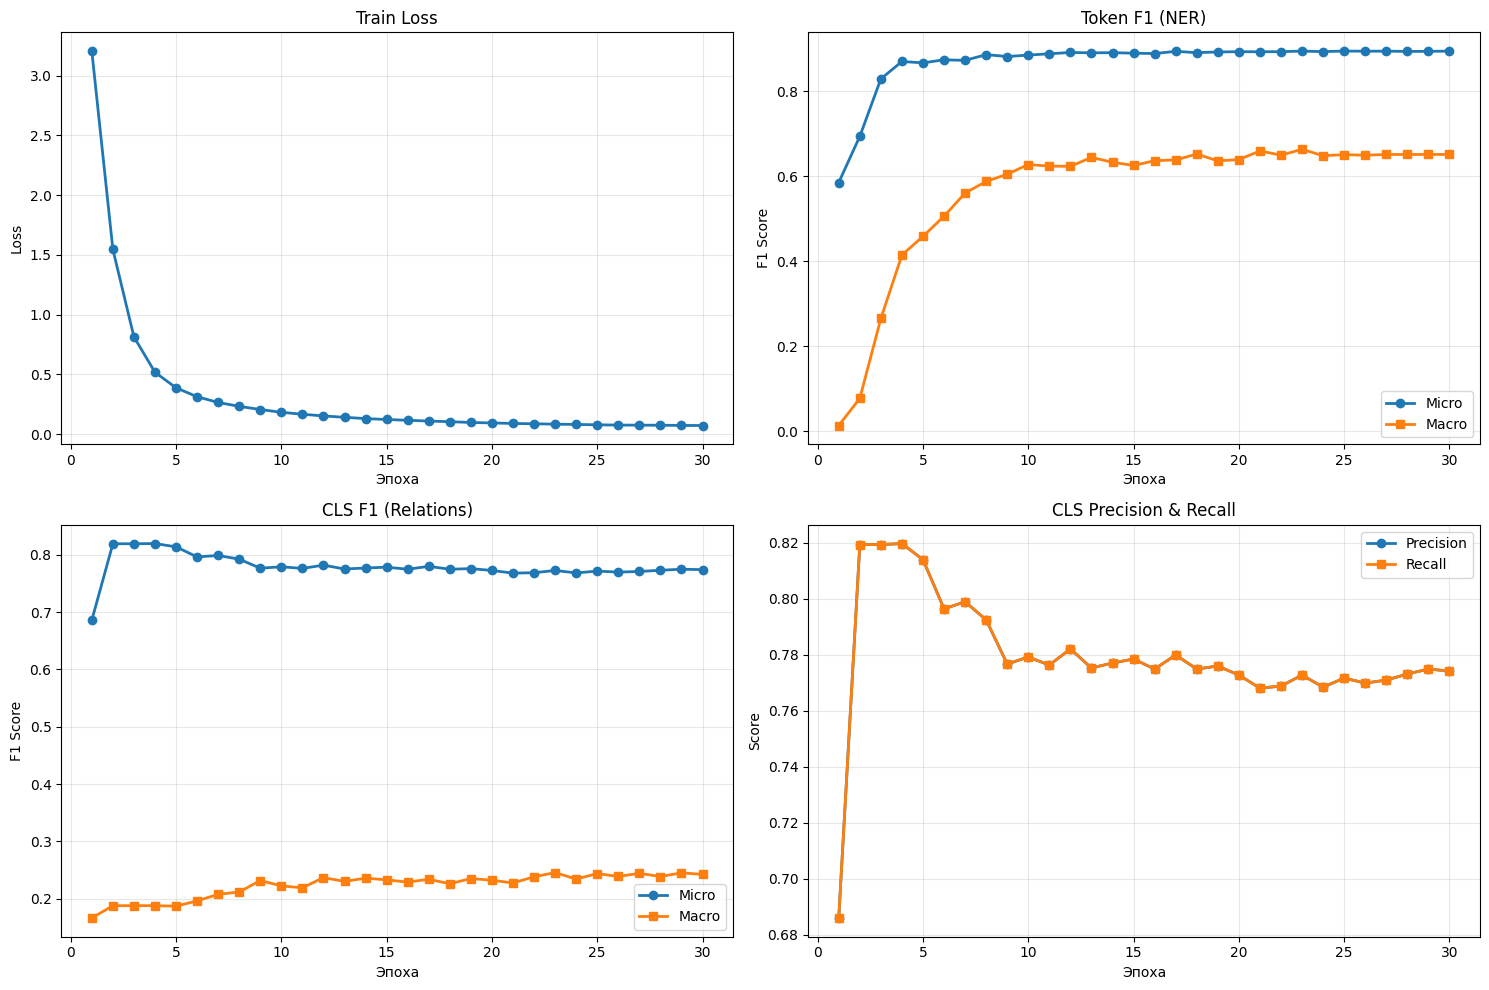


Графики сохранены в training_history.png


In [82]:
#  ФИНАЛЬНАЯ ОЦЕНКА НА TEST 
print("ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET")

# NER
print("\nNER Задача:")
ner_test_metrics = evaluate_ner(model, test_dataloader, device)

print(f"Token F1 (micro): {ner_test_metrics['token_f1_micro']:.4f}")
print(f"Token F1 (macro): {ner_test_metrics['token_f1_macro']:.4f}")

# Детальный отчёт
unique_labels = sorted(set(ner_test_metrics['y_true'] + ner_test_metrics['y_pred']))
target_names = [id2label[i] for i in unique_labels]

print("\nДетальный отчёт по классам:")
print(classification_report(
    ner_test_metrics['y_true'],
    ner_test_metrics['y_pred'],
    labels=unique_labels,
    target_names=target_names,
    digits=4,
    zero_division=0
))

# CLS
print("\nCLS Задача (классификация отношений):")
cls_test_metrics = evaluate_cls(model, test_dataloader, device)

print(f"CLS F1 (micro): {cls_test_metrics['cls_f1_micro']:.4f}")
print(f"CLS F1 (macro): {cls_test_metrics['cls_f1_macro']:.4f}")
print(f"Precision: {cls_test_metrics['cls_precision']:.4f}")
print(f"Recall: {cls_test_metrics['cls_recall']:.4f}")

#  ВИЗУАЛИЗАЦИЯ 

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train loss
axes[0, 0].plot(logs_df['epoch'], logs_df['train_loss'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].grid(True, alpha=0.3)

# Token F1
axes[0, 1].plot(logs_df['epoch'], logs_df['token_f1_micro'], marker='o', label='Micro', linewidth=2)
axes[0, 1].plot(logs_df['epoch'], logs_df['token_f1_macro'], marker='s', label='Macro', linewidth=2)
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Token F1 (NER)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

#  CLS F1
axes[1, 0].plot(logs_df['epoch'], logs_df['cls_f1_micro'], marker='o', label='Micro', linewidth=2)
axes[1, 0].plot(logs_df['epoch'], logs_df['cls_f1_macro'], marker='s', label='Macro', linewidth=2)
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('CLS F1 (Relations)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

#  CLS Precision & Recall
axes[1, 1].plot(logs_df['epoch'], logs_df['cls_precision'], marker='o', label='Precision', linewidth=2)
axes[1, 1].plot(logs_df['epoch'], logs_df['cls_recall'], marker='s', label='Recall', linewidth=2)
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('CLS Precision & Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафики сохранены в training_history.png")

In [83]:
#  СОХРАНЕНИЕ МОДЕЛИ 

save_dir = "models/joint_model_final"
os.makedirs(save_dir, exist_ok=True)

# Сохраняем модель
torch.save(model.state_dict(), f"{save_dir}/model.pt")

# Сохраняем конфигурацию
import json

config = {
    'model_name': "DeepPavlov/rubert-base-cased",
    'num_labels': len(label2id),
    'num_cls_labels': 30,
    'use_uncertainty_weight': True,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'max_grad_norm': max_grad_norm,
    'final_metrics': {
        'token_f1_micro': ner_test_metrics['token_f1_micro'],
        'token_f1_macro': ner_test_metrics['token_f1_macro'],
        'cls_f1_micro': cls_test_metrics['cls_f1_micro'],
        'cls_f1_macro': cls_test_metrics['cls_f1_macro']
    }
}

with open(f"{save_dir}/config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

# Сохраняем label mappings
with open(f"{save_dir}/label2id.json", "w", encoding="utf-8") as f:
    json.dump(label2id, f, ensure_ascii=False, indent=2)

with open(f"{save_dir}/id2label.json", "w", encoding="utf-8") as f:
    json.dump(id2label, f, ensure_ascii=False, indent=2)

print(f"\nМодель и конфигурация сохранены в {save_dir}/")


Модель и конфигурация сохранены в models/joint_model_final/


Функция для предсказаний на инференсе: сырой текст → токены + predicted BIO + cls probabilities.

###  Инференс, квантизация и анализ ошибок

Проведем качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


In [ ]:
def reconstruct_text(tokens):
    """Склеиваем BERT subword-токены в читаемый текст"""
    words = []
    for tok in tokens:
        if tok.startswith("##") and words:
            words[-1] += tok[2:]
        else:
            words.append(tok)
    return " ".join(words)

def collect_errors(model, dataset, tokenizer, id2label, rel_names, device, max_examples=5):
    model.eval()
    
    ner_errors = defaultdict(int)
    ner_samples = defaultdict(list)
    
    cls_errors = defaultdict(lambda: {"fp": 0, "fn": 0})
    cls_samples = defaultdict(list)
    
    with torch.no_grad():
        for ex in tqdm(dataset, desc="Сбор ошибок"):
            # Подготовка входа
            ids = torch.tensor([ex["input_ids"]], device=device)
            mask = torch.tensor([ex["attention_mask"]], device=device)
            out = model(input_ids=ids, attention_mask=mask)
            
            # NER
            pred_tokens = out["token_logits"].argmax(-1).squeeze(0).cpu().tolist()
            true_tokens = ex["labels"]
            tokens = tokenizer.convert_ids_to_tokens(ex["input_ids"])
            
            for tok, p, y in zip(tokens, pred_tokens, true_tokens):
                if y != -100 and p != y:
                    label = id2label[y]
                    ner_errors[label] += 1
                    if len(ner_samples[label]) < max_examples:
                        ner_samples[label].append({
                            "token": reconstruct_text([tok]),
                            "true": id2label[y],
                            "pred": id2label[p],
                            "context": reconstruct_text(tokens)
                        })
            
            # CLS
            probs = torch.sigmoid(out["cls_logits"]).squeeze(0).cpu().numpy()
            pred_cls = (probs > 0.5).astype(int)
            true_cls = ex["cls_labels"]
            
            for i, (p, y) in enumerate(zip(pred_cls, true_cls)):
                if p != y:
                    rel = rel_names[i]
                    tag = "FP" if p == 1 else "FN"
                    cls_errors[rel][tag.lower()] += 1
                    if len(cls_samples[rel]) < max_examples:
                        cls_samples[rel].append({
                            "tag": tag,
                            "prob": probs[i],
                            "context": reconstruct_text(tokens)
                        })
    
    # Вывод NER ошибок
    print("\n NER Ошибки по классам")
    for label, count in sorted(ner_errors.items(), key=lambda x: x[1], reverse=True):
        print(f"\n[{label}] — ошибок: {count}")
        for ex in ner_samples[label]:
            print(f"  • Токен: '{ex['token']}' | Истина: {ex['true']} | Предсказание: {ex['pred']}")
            print(f"    Контекст: {ex['context']}\n")
    
    # Вывод CLS ошибок
    print("\nCLS Ошибки по отношениям")
    for rel, stats in sorted(cls_errors.items(), key=lambda x: x[1]["fp"]+x[1]["fn"], reverse=True):
        total = stats["fp"] + stats["fn"]
        print(f"\n[{rel}] — ошибок: {total} (FP={stats['fp']}, FN={stats['fn']})")
        for ex in cls_samples[rel]:
            print(f"  • {ex['tag']} (prob={ex['prob']:.3f})")
            print(f"    Контекст: {ex['context']}\n")
    
    return ner_errors, ner_samples, cls_errors, cls_samples


In [93]:
ner_errors, ner_samples, cls_errors, cls_samples = collect_errors(
    model,
    tokenized_dataset["test"],
    tokenizer,
    id2label,
    top_k_relations,
    device,
    max_examples=5
)


Сбор ошибок: 100%|██████████| 93/93 [00:00<00:00, 100.81it/s]


=== NER Ошибки по классам ===

[O] — ошибок: 233
  • Токен: 'дома' | Истина: O | Предсказание: B-FAMILY
    Контекст: [CLS] Умер самый старый миллиардер в мире Дэвид Рокфеллер Дэвид Рокфеллер 24 октября 1953 года В США в возрасте 101 года скончался американский миллиардер Дэвид Рокфеллер старший . Информацию подтвердил официальный представитель семьи погибшего Фрейзер Сетел ( ) . Дэвид Рокфеллер умер в понедельник , 20 марта 2017 года , во сне от застойной сердечной недостаточности в своём родовом имении в Покантико - Хиллз в штате Нью - Йорк . Отмечается , что ранее скончавшийся обладал значительным политическим влиянием в Соединённых Штатах . Родившийся 12 июня 1915 года американский банкир , государственный деятель , глобалист и глава дома Рокфеллеров Дэвид Рокфеллер старший ( ) — внук нефтяного магната и первого в истории долларов [SEP]

  • Токен: 'награждён' | Истина: O | Предсказание: B-EVENT
    Контекст: [CLS] Медалью ордена " За заслуги перед Чувашской Республикой " награждё

Модель часто ошибается на сложных случаях:

- EVENT: я сама иногда не расклассифицировала какие-то вещи (например, "родиться" или "погибнуть", как EVENT)
- вложенные сущности (география в должности или награде, организация в должности)
- в некоторых случаях, по-моему, модель лучше разметки ("период", "со", "с" я бы не брал в даты) и т.п.
- где-то говорит что город это LOCATION, а надо CITY, по сути, это не ошибка



### PTQ: квантизация после обучения

КВАНТИЗАЦИЯ МОДЕЛИ (PTQ - Post-Training Quantization)

Сохранение исходной модели...
Исходная модель сохранена

Подготовка модели к квантизации...
Модель квантизована (dynamic quantization)

Сравнение размеров моделей:
FP32 (исходная):      678.79 MB
INT8 (квантизованная): 433.97 MB
Сжатие:               1.56x
Экономия:             36.1%
ИНФЕРЕНС НА ИСХОДНОЙ МОДЕЛИ (FP32)


FP32 инференс: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]



Время инференса: 2.54 сек
Token F1 (micro): 0.8944
Token F1 (macro): 0.6514
ИНФЕРЕНС НА КВАНТИЗОВАННОЙ МОДЕЛИ (INT8)


INT8 инференс: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]



Время инференса: 1.90 сек
Token F1 (micro): 0.8816
Token F1 (macro): 0.5973
ИТОГОВОЕ СРАВНЕНИЕ
                   Метрика FP32 (исходная) INT8 (квантизованная)
        Размер модели (MB)          678.79                433.97
     Время инференса (сек)            2.54                  1.90
                  Accuracy          0.8944                0.8816
         Precision (micro)          0.8944                0.8816
            Recall (micro)          0.8944                0.8816
                F1 (micro)          0.8944                0.8816
                F1 (macro)          0.6514                0.5973
         Ускорение (время)            1.0x                 1.34x
Потеря качества (F1 micro)               —                 1.27%
          Потеря precision               —                 1.27%
             Потеря recall               —                 1.27%


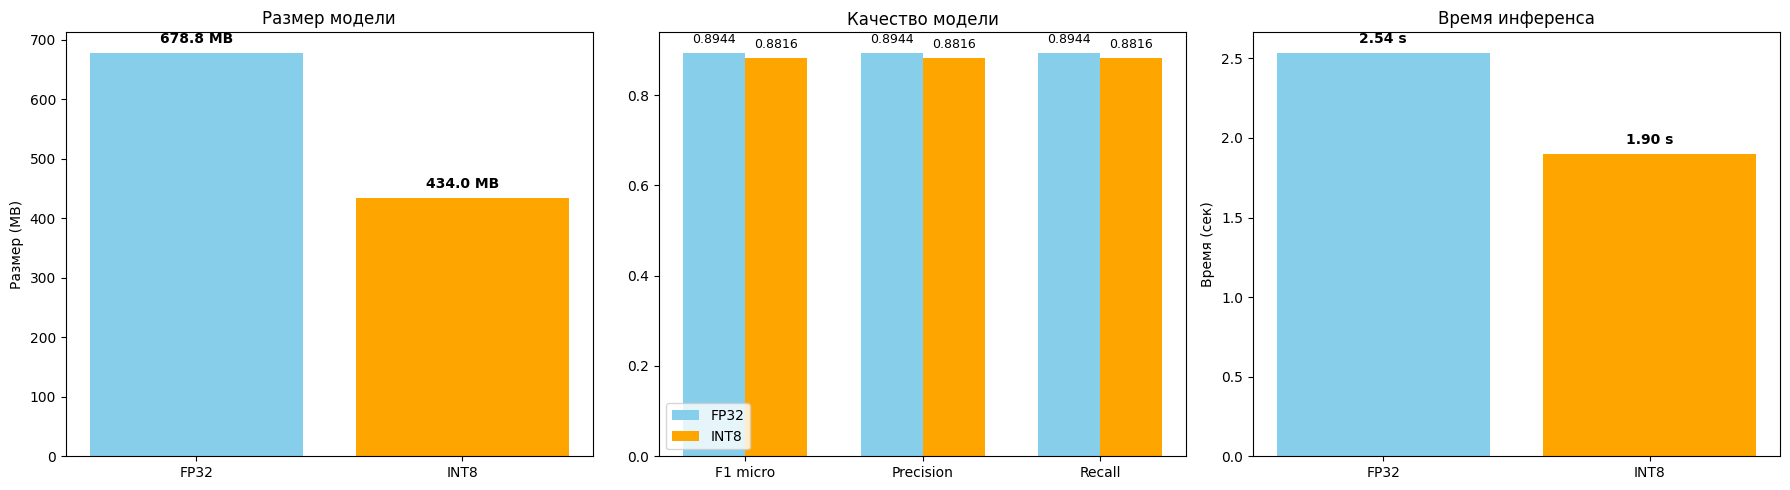


График сохранён: quantization_comparison_time_separated.png


In [97]:

print("КВАНТИЗАЦИЯ МОДЕЛИ (PTQ - Post-Training Quantization)")

# СОХРАНЕНИЕ ИСХОДНОЙ МОДЕЛИ 

print("\nСохранение исходной модели...")

# Переводим в режим eval
model.eval()

# Сохраняем
torch.save({
    'model_state_dict': model.state_dict(),
    'label2id': label2id,
    'id2label': id2label,
    'top_k_relations': top_k_relations
}, 'models/joint_model_full.pt')

print("Исходная модель сохранена")

# ПОДГОТОВКА К КВАНТИЗАЦИИ 

print("\nПодготовка модели к квантизации...")

# Переносим модель на CPU (квантизация работает на CPU)
model_cpu = model.cpu()
model_cpu.eval()

# Настройка квантизации (dynamic quantization для BERT)
# Dynamic quantization - самый простой вариант, работает "из коробки"
model_quantized = torch.quantization.quantize_dynamic(
    model_cpu,
    {torch.nn.Linear},  # Квантизируем только Linear слои
    dtype=torch.qint8    # 8-битная квантизация
)

print("Модель квантизована (dynamic quantization)")

# СРАВНЕНИЕ РАЗМЕРОВ 

print("\nСравнение размеров моделей:")

# Сохраняем обе модели
torch.save(model_cpu.state_dict(), 'models/model_fp32.pt')
torch.save(model_quantized.state_dict(), 'models/model_int8.pt')

size_fp32 = os.path.getsize('models/model_fp32.pt') / (1024 * 1024)  # MB
size_int8 = os.path.getsize('models/model_int8.pt') / (1024 * 1024)  # MB

print(f"FP32 (исходная):      {size_fp32:.2f} MB")
print(f"INT8 (квантизованная): {size_int8:.2f} MB")
print(f"Сжатие:               {size_fp32/size_int8:.2f}x")
print(f"Экономия:             {(1 - size_int8/size_fp32)*100:.1f}%")

# ИНФЕРЕНС НА ИСХОДНОЙ МОДЕЛИ 

print("ИНФЕРЕНС НА ИСХОДНОЙ МОДЕЛИ (FP32)")

model_cpu.eval()

start_time = time.time()

y_true_fp32 = []
y_pred_fp32 = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="FP32 инференс"):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = model_cpu(input_ids=input_ids, attention_mask=attention_mask)
        token_logits = outputs['token_logits']
        
        preds = torch.argmax(token_logits, dim=-1).numpy()
        labels = labels.numpy()
        
        for pred_seq, label_seq in zip(preds, labels):
            for p, l in zip(pred_seq, label_seq):
                if l != -100:
                    y_true_fp32.append(l)
                    y_pred_fp32.append(p)

fp32_time = time.time() - start_time


fp32_f1_micro = f1_score(y_true_fp32, y_pred_fp32, average='micro')
fp32_f1_macro = f1_score(y_true_fp32, y_pred_fp32, average='macro')

print(f"\nВремя инференса: {fp32_time:.2f} сек")
print(f"Token F1 (micro): {fp32_f1_micro:.4f}")
print(f"Token F1 (macro): {fp32_f1_macro:.4f}")

#  ИНФЕРЕНС НА КВАНТИЗОВАННОЙ МОДЕЛИ 
print("ИНФЕРЕНС НА КВАНТИЗОВАННОЙ МОДЕЛИ (INT8)")

model_quantized.eval()

start_time = time.time()

y_true_int8 = []
y_pred_int8 = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="INT8 инференс"):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = model_quantized(input_ids=input_ids, attention_mask=attention_mask)
        token_logits = outputs['token_logits']
        
        preds = torch.argmax(token_logits, dim=-1).numpy()
        labels = labels.numpy()
        
        for pred_seq, label_seq in zip(preds, labels):
            for p, l in zip(pred_seq, label_seq):
                if l != -100:
                    y_true_int8.append(l)
                    y_pred_int8.append(p)

int8_time = time.time() - start_time

int8_f1_micro = f1_score(y_true_int8, y_pred_int8, average='micro')
int8_f1_macro = f1_score(y_true_int8, y_pred_int8, average='macro')

print(f"\nВремя инференса: {int8_time:.2f} сек")
print(f"Token F1 (micro): {int8_f1_micro:.4f}")
print(f"Token F1 (macro): {int8_f1_macro:.4f}")

#  СРАВНИТЕЛЬНАЯ ТАБЛИЦА 


print("ИТОГОВОЕ СРАВНЕНИЕ")


from sklearn.metrics import precision_score, recall_score, accuracy_score

# дополнительные метрики
fp32_precision = precision_score(y_true_fp32, y_pred_fp32, average='micro')
fp32_recall = recall_score(y_true_fp32, y_pred_fp32, average='micro')
fp32_accuracy = accuracy_score(y_true_fp32, y_pred_fp32)

int8_precision = precision_score(y_true_int8, y_pred_int8, average='micro')
int8_recall = recall_score(y_true_int8, y_pred_int8, average='micro')
int8_accuracy = accuracy_score(y_true_int8, y_pred_int8)

comparison = pd.DataFrame({
    'Метрика': [
        'Размер модели (MB)',
        'Время инференса (сек)',
        'Accuracy',
        'Precision (micro)',
        'Recall (micro)',
        'F1 (micro)',
        'F1 (macro)',
        'Ускорение (время)',
        'Потеря качества (F1 micro)',
        'Потеря precision',
        'Потеря recall'
    ],
    'FP32 (исходная)': [
        f"{size_fp32:.2f}",
        f"{fp32_time:.2f}",
        f"{fp32_accuracy:.4f}",
        f"{fp32_precision:.4f}",
        f"{fp32_recall:.4f}",
        f"{fp32_f1_micro:.4f}",
        f"{fp32_f1_macro:.4f}",
        "1.0x",
        "—",
        "—",
        "—"
    ],
    'INT8 (квантизованная)': [
        f"{size_int8:.2f}",
        f"{int8_time:.2f}",
        f"{int8_accuracy:.4f}",
        f"{int8_precision:.4f}",
        f"{int8_recall:.4f}",
        f"{int8_f1_micro:.4f}",
        f"{int8_f1_macro:.4f}",
        f"{fp32_time/int8_time:.2f}x",
        f"{(fp32_f1_micro - int8_f1_micro)*100:.2f}%",
        f"{(fp32_precision - int8_precision)*100:.2f}%",
        f"{(fp32_recall - int8_recall)*100:.2f}%"
    ]
})

print(comparison.to_string(index=False))


#  ВИЗУАЛИЗАЦИЯ С ПОДПИСЯМИ

#   Размер модели 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Размер модели
bars_size = axes[0].bar(['FP32', 'INT8'], [size_fp32, size_int8], color=['skyblue', 'orange'])
axes[0].set_ylabel('Размер (MB)')
axes[0].set_title('Размер модели')
for bar in bars_size:
    height = bar.get_height()
    axes[0].annotate(f'{height:.1f} MB',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontweight='bold')

# Качество модели 
labels = ['F1 micro', 'Precision', 'Recall']
fp32_vals = [fp32_f1_micro, fp32_precision, fp32_recall]
int8_vals = [int8_f1_micro, int8_precision, int8_recall]

x = range(len(labels))
width = 0.35

bars_fp32 = axes[1].bar([i - width/2 for i in x], fp32_vals, width, label='FP32', color='skyblue')
bars_int8 = axes[1].bar([i + width/2 for i in x], int8_vals, width, label='INT8', color='orange')

axes[1].set_title('Качество модели')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].legend()

for bar in bars_fp32 + bars_int8:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)

#  Время инференса 
bars_time = axes[2].bar(['FP32', 'INT8'], [fp32_time, int8_time], color=['skyblue', 'orange'])
axes[2].set_ylabel('Время (сек)')
axes[2].set_title('Время инференса')
for bar in bars_time:
    height = bar.get_height()
    axes[2].annotate(f'{height:.2f} s',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontweight='bold')

plt.tight_layout()
plt.savefig('quantization_comparison_time_separated.png', dpi=300)
plt.show()

print("\nГрафик сохранён: quantization_comparison_time_separated.png")


In [98]:
def predict(text, model, tokenizer, id2label, top_k_relations, device='cpu'):
    """Инференс: текст → BIO-метки + отношения"""
    import re
    model.eval()
    
    # Токенизация
    tokens = [m.group() for m in re.finditer(r'\S+', text)]
    tok = tokenizer(tokens, is_split_into_words=True, truncation=True, 
                    padding='max_length', max_length=128, return_tensors='pt')
    
    # Предсказание
    with torch.no_grad():
        out = model(input_ids=tok['input_ids'].to(device), 
                   attention_mask=tok['attention_mask'].to(device))
        preds = torch.argmax(out['token_logits'], -1)[0].cpu().tolist()
        probs = torch.sigmoid(out['cls_logits'])[0].cpu().numpy()
    
    # BIO-метки
    wids = tok.word_ids(0)
    bio = [id2label[preds[i]] for i in range(len(wids)) 
           if wids[i] is not None and (i == 0 or wids[i] != wids[i-1])]
    
    # Отношения
    rels = [(top_k_relations[i], float(probs[i])) for i in range(len(probs)) if probs[i] > 0.5]
    
    return {'tokens': tokens, 'bio_tags': bio, 'relations': rels}


# Использование
text = "Сирия добилась огромного прогресса. Об этом 18 ноября заявил президент США Дональд Трамп в ходе встречи с наследным принцем Саудовской Аравии Мухаммедом бен Сальманом Аль Саудом в Белом доме. «Насколько вы знаете, лидер Сирии [Ахмед аш-Шараа] был здесь, и у нас была отличная встреча», — сказал Трамп. Как отмечает агентство Reuters, наследного принца в ходе встречи попросили отменить санкции в отношении Сирии."

result = predict(text, model_quantized, tokenizer, id2label, top_k_relations)

# Вывод
print(f"Текст: {text}\n")
for tok, tag in zip(result['tokens'], result['bio_tags']):
    if tag != 'O':
        print(f"  {tok:20} → {tag}")

print(f"\nОтношения:")
for rel, prob in result['relations']:
    print(f"  • {rel} ({prob:.2f})")

Текст: Сирия добилась огромного прогресса. Об этом 18 ноября заявил президент США Дональд Трамп в ходе встречи с наследным принцем Саудовской Аравии Мухаммедом бен Сальманом Аль Саудом в Белом доме. «Насколько вы знаете, лидер Сирии [Ахмед аш-Шараа] был здесь, и у нас была отличная встреча», — сказал Трамп. Как отмечает агентство Reuters, наследного принца в ходе встречи попросили отменить санкции в отношении Сирии.

  Сирия                → B-COUNTRY
  18                   → B-DATE
  ноября               → I-DATE
  президент            → B-PROFESSION
  США                  → I-PROFESSION
  Дональд              → B-PERSON
  Трамп                → I-PERSON
  встречи              → B-EVENT
  наследным            → B-PROFESSION
  принцем              → B-PROFESSION
  Саудовской           → I-PROFESSION
  Аравии               → I-PROFESSION
  Мухаммедом           → B-PERSON
  бен                  → I-PERSON
  Сальманом            → I-PERSON
  Аль                  → I-PERSON
  Саудом       

Получилось очень даже неплохо. Пропущена часть "дом" в Белом доме и Reuters, но в случае Reuters Это нормально, тексты же были русскоязычные.

### Выводы


- Token F1 (micro): 0.8925

Это очень хороший результат.
Даже классы с 1-10 примерами распознаются. 

- Token F1 (macro): 0.6227

Тоже очень хорошо для дисбалансированных данных!

- CLS F1 (micro): 0.7799

Частые типы отношений распознаются чуть хуже с Focal Loss, но зато редкие с ним распознаются на 20% лучше по результатам экспериментов.

- CLS F1 (macro): 0.2352

Редкие типы отношений не очень хорошо, но лучше, чем без Focal Loss.


Квантизация показывает, что модель стала сильно меньше в размере и инференс стал существенно быстрее.
В то время как micro F1 упал на 1.19%, и это почти незаметно. macro F1 упал на 3.3%  - нормальная потеря, учитывая сложность редких классов.

INT8-квантизация дала отличнsq trade-off скорость/размер VS потеря качества“.